<a href="https://colab.research.google.com/github/HaqTetsuya/ChatbotPerpusBipa/blob/main/IndobertPerpusChatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title download dependancy
# Cell 1: Instalasi library yang diperlukan
!pip install transformers torch pandas scikit-learn matplotlib seaborn tqdm deep-translator fuzzywuzzy Levenshtein


In [ ]:
# @title import dependency, load drive, and github {"form-width":"20%"}
!git clone https://github.com/HaqTetsuya/ChatbotPerpusBipa.git

import json
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns
from google.colab import drive, files
from plotly.subplots import make_subplots
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report
#from tqdm import tqdm
from tqdm.auto import tqdm  # If you need both tqdm and tqdm.auto
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_scheduler

drive.mount('/content/drive')
FName = "RusdiIntents" #@param {type:"string"}

# Update MODEL_SAVE_PATH with user input
MODEL_SAVE_PATH = f"/content/drive/MyDrive/{FName}"


# Cell 4: Kelas Dataset untuk IndoBERT
class IntentDataset(Dataset):
    """Dataset untuk klasifikasi intent dengan IndoBERT"""

    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        # Convert dict of tensors to flat tensors
        item = {key: val.squeeze(0) for key, val in encoding.items()}
        item['labels'] = torch.tensor(label)

        return item

In [5]:
# @title load data

def load_csv_data(csv_path, label_encoder=None, show_distribution=False):
    """Memuat data intent dari file CSV. Bisa untuk train/test tanpa split."""
    print(f"\nMemuat data dari: {csv_path}")

    if not os.path.exists(csv_path):
        raise FileNotFoundError(f"File tidak ditemukan: {csv_path}")

    df = pd.read_csv(csv_path)

    if 'text' not in df.columns or 'intent' not in df.columns:
        raise ValueError("Kolom 'text' dan 'intent' harus ada di CSV")

    if label_encoder is None:
        label_encoder = LabelEncoder()
        df['intent_encoded'] = label_encoder.fit_transform(df['intent'])
        intent_classes = label_encoder.classes_
        print(f"Label encoder baru dibuat dari data {csv_path}")
    else:
        df['intent_encoded'] = label_encoder.transform(df['intent'])
        intent_classes = label_encoder.classes_
        print(f"Menggunakan label encoder yang sudah ada")

    if show_distribution:
        intent_counts = df['intent'].value_counts()
        print("\nDistribusi intent:")
        for intent, count in intent_counts.items():
            print(f"  {intent}: {count}")

        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        sns.barplot(x=intent_counts.index, y=intent_counts.values, palette="viridis")
        plt.xlabel("Intent")
        plt.ylabel("Jumlah Sampel")
        plt.title("Distribusi Intent")
        plt.xticks(rotation=45)

        plt.subplot(1, 2, 2)
        plt.pie(intent_counts, labels=intent_counts.index, autopct='%1.1f%%', colors=sns.color_palette("viridis", len(intent_counts)))
        plt.title("Proporsi Intent")
        plt.tight_layout()
        plt.show()

    texts = df['text'].values
    labels = df['intent_encoded'].values

    return texts, labels, intent_classes, label_encoder


In [6]:
# @title  setup model IndoBERT
def setup_indobert_for_intent(num_labels):
    """Load model IndoBERT untuk klasifikasi intent"""

    print("Memuat model IndoBERT...")
    tokenizer = AutoTokenizer.from_pretrained("indobenchmark/indobert-base-p2")
    model = AutoModelForSequenceClassification.from_pretrained(
        "indobenchmark/indobert-base-p2",
        num_labels=num_labels
    )
    print("Model berhasil dimuat")

    return model, tokenizer

In [7]:
# @title OOD
def enhanced_calibrate_ood(model, tokenizer, val_dataloader, save_path, temperature=1.0, percentile=85, margin=0.1):
    """
    Calibrate and save OOD thresholds with adjustable tolerance
    """
    print("Calibrating threshold for OOD detection...")
    thresholds = calibrate_ood_detection(model, tokenizer, val_dataloader,
                                        temperature=temperature,
                                        percentile=percentile,
                                        margin=margin)

    print(f"Energy threshold: {thresholds['energy_threshold']:.4f}")
    print(f"MSP threshold: {thresholds['msp_threshold']:.4f}")

    # Save thresholds
    save_ood_thresholds(thresholds, save_path)

    return thresholds

def calibrate_ood_detection(model, tokenizer, dataloader, temperature=1.0, percentile=70, margin=0.1):
    """
    Calibrate thresholds for OOD detection using in-distribution data
    with Energy-based and MSP (Maximum Softmax Probability) methods
    """
    device = next(model.parameters()).device
    model.eval()

    # For Energy method and MSP method
    energy_scores = []
    msp_scores = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Calibrating OOD detection"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            outputs = model(**inputs)
            logits = outputs.logits

            # Energy score (higher values for OOD)
            energy = -temperature * torch.logsumexp(logits / temperature, dim=1)
            energy_scores.extend(energy.cpu().numpy())

            # MSP score (lower values for OOD)
            softmax_probs = F.softmax(logits, dim=1)
            max_probs, _ = torch.max(softmax_probs, dim=1)
            msp_scores.extend(max_probs.cpu().numpy())

    # Calculate threshold for Energy with margin (make more tolerant)
    base_energy_threshold = np.percentile(energy_scores, percentile)
    # Apply margin to make more tolerant (increase threshold)
    energy_threshold = base_energy_threshold * (1 + margin)

    # Calculate threshold for MSP with margin
    base_msp_threshold = np.percentile(msp_scores, 100 - percentile)
    # Apply margin to make more tolerant (decrease threshold)
    msp_threshold = base_msp_threshold * (1 - margin)

    return {
        "energy_threshold": float(energy_threshold),
        "msp_threshold": float(msp_threshold)
    }

def predict_with_ood_detection(model, tokenizer, text, thresholds, temperature=1.0, tolerance_factor=1.0):
    """
    Predict with adjustable OOD detection tolerance
    """
    device = next(model.parameters()).device
    model.eval()

    # Apply the tolerance factor to thresholds
    energy_threshold = thresholds["energy_threshold"] * tolerance_factor
    msp_threshold = thresholds["msp_threshold"] / tolerance_factor if thresholds["msp_threshold"] else None

    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

        # Energy score
        energy = -temperature * torch.logsumexp(logits / temperature, dim=1)
        energy_score = energy.item()

        # MSP score
        softmax_probs = F.softmax(logits, dim=1)
        max_probs, predicted_class = torch.max(softmax_probs, dim=1)
        msp_score = max_probs.item()

        # OOD detection
        is_ood_energy = energy_score > energy_threshold
        is_ood_msp = msp_score < msp_threshold if msp_threshold else False

        # Combined OOD detection (can adjust this logic for tolerance)
        is_ood = is_ood_energy  # You can use different combinations

        return {
            "prediction": predicted_class.item(),
            "confidence": msp_score,
            "energy_score": energy_score,
            "is_ood": is_ood,
            "is_ood_energy": is_ood_energy,
            "is_ood_msp": is_ood_msp
        }

def save_ood_thresholds(thresholds, save_path):
    """
    Save OOD thresholds to JSON file
    """
    threshold_file = os.path.join(save_path, "ood_thresholds.json")
    with open(threshold_file, 'w') as f:
        json.dump(thresholds, f, indent=4)
    print(f"OOD thresholds saved at {threshold_file}")
    return threshold_file

def load_ood_thresholds(model_path):
    """
    Load OOD thresholds from JSON file
    """
    try:
        with open(os.path.join(model_path, "ood_thresholds.json"), 'r') as f:
            thresholds = json.load(f)
            return thresholds
    except FileNotFoundError:
        try:
            with open(os.path.join(model_path, "ood_threshold.json"), 'r') as f:
                threshold_data = json.load(f)
                return {
                    "energy_threshold": threshold_data["energy_threshold"],
                    "msp_threshold": None
                }
        except FileNotFoundError:
            print("Warning: OOD threshold files not found. Using default thresholds.")
            return {
                "energy_threshold": 0.0,
                "msp_threshold": 0.5
            }

In [8]:
# @title Focal LOSS
import torch.nn.functional as F
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none', weight=self.alpha)
        pt = torch.exp(-ce_loss)
        focal_loss = (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [9]:
#@title Training function

def train_intent_classifier(model, tokenizer, train_texts, train_labels, val_texts, val_labels,
                           batch_size=16, epochs=10, learning_rate=2e-5, weight_decay=0.01,
                           save_path=MODEL_SAVE_PATH, use_class_weights=True, patience=3, class_names=None):
    """
    Melatih model IndoBERT untuk klasifikasi intent dengan perbaikan:
    - Enhanced visualization (interactive and static)
    - Per-class metric tracking
    - Confusion matrix generation
    - Batch-level metric tracking
    - Learning rate visualization
    """

    # Persiapkan dataset
    print("Menyiapkan dataset...")
    train_dataset = IntentDataset(train_texts, train_labels, tokenizer)
    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

    # Compute class weights if needed
    class_weights = None
    if use_class_weights:
        unique_classes = np.unique(train_labels)
        weights = compute_class_weight(
            class_weight='balanced',
            classes=unique_classes,
            y=train_labels
        )
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        class_weights = torch.FloatTensor(weights).to(device)
        print(f"Menggunakan class weights: {weights}")

    # Optimizer dengan weight decay untuk regularisasi
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Scheduler dengan warmup
    num_training_steps = len(train_dataloader) * epochs
    num_warmup_steps = int(0.1 * num_training_steps)  # 10% warmup
    scheduler = get_scheduler("cosine", optimizer=optimizer,
                             num_warmup_steps=num_warmup_steps,
                             num_training_steps=num_training_steps)

    # Cek untuk GPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Menggunakan device: {device}")
    model.to(device)
    print(f"Mulai pelatihan model...")
    print(f"Total epoch: {epochs}, batch size: {batch_size}, learning rate: {learning_rate}, weight decay: {weight_decay}")

    # Create loss function with class weights if needed
    # Create Focal Loss with class weights
    loss_fn = FocalLoss(alpha=class_weights, gamma=2.0)
    print("Menggunakan Focal Loss dengan gamma=2.0")

    # Initialize training history
    history = initialize_training_history()
    best_val_loss = float('inf')
    counter = 0  # Counter for early stopping

    for epoch in range(epochs):
        # Training phase
        train_loss = run_training_epoch(model, device, train_dataloader, optimizer,
                                        scheduler, loss_fn, epoch, epochs, history)
        history['train_loss'].append(train_loss)

        # Validation phase
        val_metrics = run_validation_epoch(model, device, val_dataloader, loss_fn, epoch, epochs)
        update_history_with_validation_metrics(history, val_metrics)

        # Update per-class metrics if class names are provided
        if class_names is not None:
            update_per_class_metrics(history, val_metrics['all_labels'], val_metrics['all_preds'])

            # Generate confusion matrix for this epoch
            plot_confusion_matrix(val_metrics['all_labels'], val_metrics['all_preds'], class_names, epoch, save_path)

        # Print detailed metrics
        print_epoch_metrics(epoch, epochs, train_loss, val_metrics)

        # Early stopping and model saving logic
        counter = handle_early_stopping(model, tokenizer, val_metrics['avg_val_loss'],
                                      best_val_loss, counter, patience,
                                      save_path, val_metrics['all_labels'],
                                      val_metrics['all_preds'])

        if counter >= patience:
            print(f"Early stopping triggered setelah {epoch+1} epochs")
            break

        # Update best validation loss if improved
        if val_metrics['avg_val_loss'] < best_val_loss:
            best_val_loss = val_metrics['avg_val_loss']

    print(f"Pelatihan selesai! Model terbaik disimpan di {save_path}")

    # Generate enhanced visualizations
    enhanced_plot_training_results(history, save_path, class_names=class_names)

    # Simpan history ke file JSON
    save_enhanced_history(history, save_path)

    return model, history

def initialize_training_history():
    """Initialize the training history dictionary with all required keys"""
    return {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_f1': [],
        'val_precision': [],
        'val_recall': [],
        'batch_metrics': {
            'iteration': [],
            'loss': [],
            'epoch': [],
            'progress': [],
            'learning_rates': []
        },
        'class_f1': [],  # Per-class F1 scores
        'class_precision': [],  # Per-class precision
        'class_recall': []  # Per-class recall
    }

def run_training_epoch(model, device, train_dataloader, optimizer, scheduler, loss_fn, epoch, epochs, history):
    """Run a single training epoch and return average loss"""
    model.train()
    train_loss = 0
    print(f"\nEpoch {epoch+1}/{epochs} - Training dimulai...")
    progress_bar = tqdm(enumerate(train_dataloader), total=len(train_dataloader),
                      desc=f"Epoch {epoch+1}/{epochs} [Training]", leave=False)

    for batch_idx, batch in progress_bar:
        try:
            # Pindahkan batch ke device
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            # Forward pass with custom loss function
            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()

            # Track batch-level metrics
            update_batch_metrics(history, batch_idx, loss.item(), epoch, len(train_dataloader), optimizer)

            train_loss += loss.item()
            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

        except RuntimeError as e:
            if "out of memory" in str(e):
                print("Peringatan: Kehabisan memori! Membersihkan cache...")
                torch.cuda.empty_cache()
                continue
            else:
                raise e

    return train_loss / len(train_dataloader)

def update_batch_metrics(history, batch_idx, loss_item, epoch, iterations_per_epoch, optimizer):
    """Update history with batch-level metrics"""
    global_iteration = epoch * iterations_per_epoch + batch_idx
    progress = (epoch + (batch_idx / iterations_per_epoch)) * 100

    history['batch_metrics']['iteration'].append(global_iteration)
    history['batch_metrics']['loss'].append(loss_item)
    history['batch_metrics']['epoch'].append(epoch)
    history['batch_metrics']['progress'].append(progress)
    history['batch_metrics']['learning_rates'].append(optimizer.param_groups[0]['lr'])

def run_validation_epoch(model, device, val_dataloader, loss_fn, epoch, epochs):
    """Run a single validation epoch and return metrics"""
    model.eval()
    val_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    print(f"Epoch {epoch+1}/{epochs} - Validasi dimulai...")
    progress_bar = tqdm(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)

    with torch.no_grad():
        for batch in progress_bar:
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            val_loss += loss.item()

            # Calculate accuracy
            predictions = torch.argmax(outputs.logits, dim=1)
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

            # Collect predictions and labels for metrics
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            progress_bar.set_postfix({'loss': f"{loss.item():.4f}"})

    # Calculate metrics
    avg_val_loss = val_loss / len(val_dataloader)
    accuracy = correct / total
    f1 = f1_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)

    return {
        'avg_val_loss': avg_val_loss,
        'accuracy': accuracy,
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'all_preds': all_preds,
        'all_labels': all_labels
    }

def update_history_with_validation_metrics(history, val_metrics):
    """Update history with validation metrics"""
    history['val_loss'].append(val_metrics['avg_val_loss'])
    history['val_accuracy'].append(val_metrics['accuracy'])
    history['val_f1'].append(val_metrics['f1'])
    history['val_precision'].append(val_metrics['precision'])
    history['val_recall'].append(val_metrics['recall'])

def update_per_class_metrics(history, all_labels, all_preds):
    """Update per-class metrics in history"""
    class_f1 = f1_score(all_labels, all_preds, average=None, zero_division=0)
    class_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
    class_recall = recall_score(all_labels, all_preds, average=None, zero_division=0)

    history['class_f1'].append(class_f1.tolist())
    history['class_precision'].append(class_precision.tolist())
    history['class_recall'].append(class_recall.tolist())

def print_epoch_metrics(epoch, epochs, avg_train_loss, val_metrics):
    """Print detailed metrics for an epoch"""
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"  Train Loss: {avg_train_loss:.4f}")
    print(f"  Val Loss: {val_metrics['avg_val_loss']:.4f}, Val Accuracy: {val_metrics['accuracy']*100:.2f}%")
    print(f"  Val F1: {val_metrics['f1']:.4f}, Val Precision: {val_metrics['precision']:.4f}, Val Recall: {val_metrics['recall']:.4f}")
    if 'all_labels' in val_metrics and 'all_preds' in val_metrics:
        print(f"\nClass-wise precision/recall/F1 setelah epoch {epoch+1}:")
        print(classification_report(val_metrics['all_labels'], val_metrics['all_preds'], digits=4))
def handle_early_stopping(model, tokenizer, avg_val_loss, best_val_loss, counter, patience, save_path, all_labels, all_preds):
    """Handle early stopping logic and model saving"""
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        counter = 0  # Reset early stopping counter

        if not os.path.exists(save_path):
            os.makedirs(save_path)

        print(f"Menyimpan model terbaik ke {save_path}")
        model.save_pretrained(save_path)
        tokenizer.save_pretrained(save_path)

        # Save classification report for best model
        report = classification_report(all_labels, all_preds, output_dict=True)
        with open(os.path.join(save_path, "classification_report.json"), 'w') as f:
            json.dump(report, f, indent=4)
    else:
        counter += 1
        print(f"Validation loss tidak membaik. Early stopping counter: {counter}/{patience}")

    return counter

In [10]:
# @title Evaluation
def evaluate_model_enhanced(model, tokenizer, val_texts, val_labels, intent_classes, save_path):
    """Enhanced model evaluation with better visualizations"""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    model.to(device)

    # Prepare dataset and dataloader
    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)
    val_dataloader = DataLoader(val_dataset, batch_size=16)

    all_preds = []
    all_labels = []

    # Evaluation loop
    with torch.no_grad():
        for batch in tqdm(val_dataloader, desc="Evaluasi Model"):
            inputs = {k: v.to(device) for k, v in batch.items() if k != 'labels'}
            labels = batch['labels'].to(device)

            outputs = model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    # Generate classification report
    report = classification_report(all_labels, all_preds,
                                 target_names=intent_classes,
                                 output_dict=True)

    # Create dataframe for visualization
    report_df = pd.DataFrame(report).transpose()
    report_df = report_df.round(3)

    # Filter for class metrics only (exclude summary rows)
    class_df = report_df.loc[intent_classes]
    metrics = ['precision', 'recall', 'f1-score']

    # Save classification metrics as CSV
    report_df.to_csv(os.path.join(save_path, "classification_report.csv"))

    # Create visualizations
    create_static_visualizations(cm, class_df, metrics, intent_classes, save_path)
    create_interactive_visualizations(cm, class_df, metrics, intent_classes, save_path)

    # Print report summary
    print("\nModel Evaluation Report:")
    print(f"Overall Accuracy: {report['accuracy']:.4f}")
    print(f"Macro F1-score: {report['macro avg']['f1-score']:.4f}")
    print(f"Weighted F1-score: {report['weighted avg']['f1-score']:.4f}")

    return report, cm

def create_static_visualizations(cm, class_df, metrics, intent_classes, save_path):
    """Create and save static matplotlib visualizations"""
    # Confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
               xticklabels=intent_classes, yticklabels=intent_classes)
    plt.title('Confusion Matrix - Final Model')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "final_confusion_matrix.png"))
    plt.close()

    # Classification report heatmap
    plt.figure(figsize=(12, len(intent_classes)*0.5 + 3))
    sns.heatmap(class_df[metrics], annot=True, cmap='YlGnBu', fmt='.3f',
               yticklabels=intent_classes, cbar=True)
    plt.title('Performance Metrics by Intent Class')
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "class_performance_metrics.png"))
    plt.close()

def create_interactive_visualizations(cm, class_df, metrics, intent_classes, save_path):
    """Create and save interactive plotly visualizations"""
    # Interactive confusion matrix
    fig_cm = px.imshow(cm,
                   labels=dict(x="Predicted Label", y="True Label", color="Count"),
                   x=intent_classes, y=intent_classes,
                   text_auto=True,
                   color_continuous_scale='Blues')

    fig_cm.update_layout(
        title='Confusion Matrix (Interactive)',
        width=900,
        height=800
    )
    fig_cm.write_html(os.path.join(save_path, "interactive_confusion_matrix.html"))

    # Interactive performance metrics
    fig_perf = px.imshow(class_df[metrics],
                   labels=dict(x="Metric", y="Intent Class", color="Score"),
                   x=metrics, y=intent_classes,
                   text_auto=True,
                   color_continuous_scale='YlGnBu')

    fig_perf.update_layout(
        title='Performance Metrics by Intent Class (Interactive)',
        width=800,
        height=max(400, len(intent_classes)*30)
    )
    fig_perf.write_html(os.path.join(save_path, "interactive_class_performance.html"))

In [11]:
# @title Teks judul default
def enhanced_plot_training_results(history, save_path, class_names=None):
    """
    Enhanced function to plot training results with more detailed visualizations

    Args:
        history: Dictionary containing training history metrics
        save_path: Path to save visualization files
        class_names: Optional list of class names for confusion matrix
    """
    # Create the static plots (same as before for compatibility)
    static_plot_training_results(history, save_path)

    # Create interactive plotly visualizations
    interactive_plot_training_results(history, save_path)

    # If we have class metrics in our history, plot those too
    if 'class_f1' in history and class_names is not None:
        plot_class_metrics(history, save_path, class_names)

    # If we tracked learning rates, plot those
    if 'batch_metrics' in history and 'learning_rates' in history['batch_metrics']:
        plot_learning_rate(history, save_path)

def static_plot_training_results(history, save_path):
    """Plot and save training metrics using matplotlib (static)"""
    plt.figure(figsize=(15, 10))

    # Plot 1: Loss
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss', marker='o')
    plt.plot(history['val_loss'], label='Validation Loss', marker='o')
    plt.title('Loss selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot 2: Accuracy
    plt.subplot(2, 2, 2)
    plt.plot(history['val_accuracy'], label='Validation Accuracy', marker='o', color='green')
    plt.title('Akurasi selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot 3: F1 Score
    plt.subplot(2, 2, 3)
    plt.plot(history['val_f1'], label='Validation F1', marker='o', color='purple')
    plt.title('F1 Score selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)

    # Plot 4: Precision & Recall
    plt.subplot(2, 2, 4)
    plt.plot(history['val_precision'], label='Validation Precision', marker='o', color='orange')
    plt.plot(history['val_recall'], label='Validation Recall', marker='o', color='brown')
    plt.title('Precision & Recall selama Training')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    # Save the plot
    plt.savefig(os.path.join(save_path, "training_metrics.png"))
    plt.close()

def interactive_plot_training_results(history, save_path):
    """Create interactive plotly visualizations of training metrics"""
    # Create epochs list for x-axis
    epochs = list(range(1, len(history['train_loss']) + 1))

    # Create a DataFrame for easier plotting
    df = pd.DataFrame({
        'Epoch': epochs,
        'Training Loss': history['train_loss'],
        'Validation Loss': history['val_loss'],
        'Validation Accuracy': history['val_accuracy'],
        'Validation F1': history['val_f1'],
        'Validation Precision': history['val_precision'],
        'Validation Recall': history['val_recall']
    })

    # Create subplot figure
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Loss', 'Accuracy', 'F1 Score', 'Precision & Recall'),
        vertical_spacing=0.15,
        horizontal_spacing=0.1
    )

    # Add traces for each metric
    # Loss plot
    fig.add_trace(
        go.Scatter(x=epochs, y=history['train_loss'], mode='lines+markers', name='Training Loss'),
        row=1, col=1
    )
    fig.add_trace(
        go.Scatter(x=epochs, y=history['val_loss'], mode='lines+markers', name='Validation Loss'),
        row=1, col=1
    )

    # Accuracy plot
    fig.add_trace(
        go.Scatter(x=epochs, y=history['val_accuracy'], mode='lines+markers', name='Validation Accuracy', line=dict(color='green')),
        row=1, col=2
    )

    # F1 Score plot
    fig.add_trace(
        go.Scatter(x=epochs, y=history['val_f1'], mode='lines+markers', name='Validation F1', line=dict(color='purple')),
        row=2, col=1
    )

    # Precision & Recall plot
    fig.add_trace(
        go.Scatter(x=epochs, y=history['val_precision'], mode='lines+markers', name='Validation Precision', line=dict(color='orange')),
        row=2, col=2
    )
    fig.add_trace(
        go.Scatter(x=epochs, y=history['val_recall'], mode='lines+markers', name='Validation Recall', line=dict(color='brown')),
        row=2, col=2
    )

    # Update layout
    fig.update_layout(
        height=800,
        width=1200,
        title_text="Training Metrics (Interactive)",
        hovermode="x unified"
    )

    # Save interactive plot as HTML
    fig.write_html(os.path.join(save_path, "interactive_training_metrics.html"))

    # Create a combined metrics plot for better trend comparison
    fig_combined = px.line(
        df,
        x='Epoch',
        y=['Training Loss', 'Validation Loss', 'Validation Accuracy', 'Validation F1', 'Validation Precision', 'Validation Recall'],
        title='All Training Metrics',
        labels={'value': 'Metric Value', 'variable': 'Metric'}
    )

    fig_combined.update_layout(height=600, width=1000, hovermode="x unified")
    fig_combined.write_html(os.path.join(save_path, "combined_metrics.html"))

def plot_confusion_matrix(all_labels, all_preds, class_names, epoch, save_path):
    """Plot and save confusion matrix for the epoch"""
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title(f'Confusion Matrix - Epoch {epoch+1}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

    # Save the confusion matrix
    cm_dir = os.path.join(save_path, "confusion_matrices")
    os.makedirs(cm_dir, exist_ok=True)
    plt.savefig(os.path.join(cm_dir, f"cm_epoch_{epoch+1}.png"))
    plt.close()

def plot_class_metrics(history, save_path, class_names):
    """Plot per-class performance metrics"""
    # Create directory for class metrics
    os.makedirs(os.path.join(save_path, "class_metrics"), exist_ok=True)

    # Plot F1 per class if available
    if 'class_f1' in history:
        plt.figure(figsize=(12, 8))

        # Convert dictionary structure to usable format
        epochs = len(history['class_f1'])
        x_epochs = list(range(1, epochs + 1))

        for i, class_name in enumerate(class_names):
            class_f1 = [history['class_f1'][epoch][i] for epoch in range(epochs)]
            plt.plot(x_epochs, class_f1, marker='o', label=f'{class_name}')

        plt.title('F1 Score per Class')
        plt.xlabel('Epoch')
        plt.ylabel('F1 Score')
        plt.grid(True)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.savefig(os.path.join(save_path, "class_metrics", "f1_per_class.png"))
        plt.close()

        # Interactive version with plotly
        fig = go.Figure()
        for i, class_name in enumerate(class_names):
            class_f1 = [history['class_f1'][epoch][i] for epoch in range(epochs)]
            fig.add_trace(go.Scatter(
                x=x_epochs,
                y=class_f1,
                mode='lines+markers',
                name=class_name
            ))

        fig.update_layout(
            title='F1 Score per Class (Interactive)',
            xaxis_title='Epoch',
            yaxis_title='F1 Score',
            height=600,
            width=1000,
            hovermode="x unified"
        )
        fig.write_html(os.path.join(save_path, "class_metrics", "f1_per_class.html"))

def plot_learning_rate(history, save_path):
    """Plot learning rate changes over training"""
    # Extract learning rates from batch metrics
    iterations = history['batch_metrics']['iteration']
    learning_rates = history['batch_metrics']['learning_rates']
    epochs = history['batch_metrics']['epoch']

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(iterations, learning_rates)
    plt.title('Learning Rate Schedule')
    plt.xlabel('Iteration')
    plt.ylabel('Learning Rate')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(save_path, "learning_rate_schedule.png"))
    plt.close()

    # Interactive version
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=iterations,
        y=learning_rates,
        mode='lines',
        name='Learning Rate'
    ))

    fig.update_layout(
        title='Learning Rate Schedule (Interactive)',
        xaxis_title='Iteration',
        yaxis_title='Learning Rate',
        height=500,
        width=900
    )
    fig.write_html(os.path.join(save_path, "learning_rate_schedule.html"))

def save_enhanced_history(history, save_path):
    """Save enhanced training history with additional visualizations"""
    # Convert numpy arrays to lists for JSON serialization
    processed_history = {}

    for key, value in history.items():
        if isinstance(value, dict):
            processed_history[key] = {}
            for subkey, subvalue in value.items():
                processed_history[key][subkey] = convert_to_serializable(subvalue)
        else:
            processed_history[key] = convert_to_serializable(value)

    # Save the enhanced history
    with open(os.path.join(save_path, "enhanced_training_history.json"), 'w') as f:
        json.dump(processed_history, f, indent=4)

    print(f"Enhanced training history saved to {os.path.join(save_path, 'enhanced_training_history.json')}")

def convert_to_serializable(value):
    """Convert numpy arrays and other non-serializable types to JSON-compatible types"""
    if isinstance(value, np.ndarray):
        return value.tolist()
    elif isinstance(value, list):
        if value and isinstance(value[0], np.ndarray):
            return [item.tolist() if isinstance(item, np.ndarray) else item for item in value]
        else:
            return value
    else:
        return value

In [12]:
# @title PredictionIntent
def predict_intent_with_enhanced_ood(text, model, tokenizer, intent_classes,
                                     energy_threshold, msp_threshold=None,
                                     temperature=1.0, method='combined',
                                     label_encoder=None, device=None,
                                     return_logits=False):
    """
    Memprediksi intent dari teks input dengan deteksi Out-of-Distribution yang ditingkatkan

    Args:
        text: Teks input untuk diprediksi
        model: Model yang sudah dilatih
        tokenizer: Tokenizer untuk model
        intent_classes: List nama intent
        energy_threshold: Threshold untuk energy-based OOD detection
        msp_threshold: Threshold untuk MSP-based OOD detection
        temperature: Parameter temperature untuk energy
        method: Metode deteksi OOD - 'energy', 'msp', atau 'combined'
        label_encoder: Label encoder untuk intent classes
        device: Device untuk inference
        return_logits: Jika True, mengembalikan logits asli

    Returns:
        dict: Hasil prediksi dengan detail OOD detection
    """
    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    if isinstance(text, str):
        text = [text]  # Convert single text to list

    model.to(device)
    model.eval()

    # Tokenisasi input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    # List untuk menyimpan hasil setiap input
    results = []

    # Prediksi
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits

        # Hitung energy score: -T*log(sum(exp(logits/T)))
        energy = -temperature * torch.logsumexp(logits / temperature, dim=1)

        # Hitung confidence dengan softmax
        probabilities = torch.softmax(logits, dim=1)
        predictions = torch.argmax(probabilities, dim=1)
        max_probs = torch.max(probabilities, dim=1)[0]

        for i in range(len(text)):
            prediction = predictions[i].item()
            energy_score = energy[i].item()
            confidence = max_probs[i].item()

            # Deteksi OOD berdasarkan metode yang dipilih
            is_ood_energy = energy_score > energy_threshold if energy_threshold is not None else False
            is_ood_msp = confidence < msp_threshold if msp_threshold is not None else False

            if method == 'energy':
                is_ood = is_ood_energy
            elif method == 'msp':
                is_ood = is_ood_msp
            else:  # 'combined'
                is_ood = is_ood_energy and is_ood_msp

            # Tentukan intent berdasarkan hasil OOD detection
            if is_ood:
                predicted_intent = "unknown"
                topk_intents = [("unknown", 1.0)]  # Unknown intent dengan confidence 100%
            else:
                predicted_intent = intent_classes[prediction]

                # Dapatkan top 3 intent dengan confidence tertinggi
                top_k = min(3, len(intent_classes))
                topk_values, topk_indices = torch.topk(probabilities[i], top_k)
                topk_intents = [(intent_classes[idx.item()], val.item())
                                for idx, val in zip(topk_indices, topk_values)]

            # Buat hasil untuk input ini
            result = {
                "text": text[i],
                "intent": predicted_intent,
                "confidence": confidence,
                "energy_score": energy_score,
                "is_ood": is_ood,
                "is_ood_energy": is_ood_energy,
                "is_ood_msp": is_ood_msp if msp_threshold is not None else None,
                "top_intents": topk_intents
            }

            if return_logits:
                result["logits"] = logits[i].cpu().numpy()

            results.append(result)

    # Jika hanya satu input, kembalikan hasil langsung tanpa list
    if len(text) == 1:
        return results[0]
    return results

In [13]:
# @title Run pipeline
def run_full_pipeline_enhanced(
    use_drive=True,
    percentile=95,
    ood_method='combined',
    split_dataset="no",
    val_split=0.2,
    batch_size=16,
    epochs=10,
    learning_rate=2e-5,
    weight_decay=0.01,
    patience=3,
    train_csv_path="train.csv",
    val_csv_path="val.csv"
):
    """Jalankan pipeline lengkap dengan enhanced OOD detection dan visualisasi yang ditingkatkan

    Parameters:
    -----------
    use_drive : bool
        Apakah menggunakan Google Drive untuk penyimpanan
    percentile : int
        Persentil untuk threshold OOD detection
    ood_method : str
        Metode OOD detection ('msp', 'energy', 'combined')
    split_dataset : str
        Mode pemisahan dataset ("yes" untuk split dari train.csv, "no" untuk file terpisah)
    val_split : float
        Proporsi data validasi jika split_dataset="yes"
    batch_size : int
        Ukuran batch untuk training dan evaluasi
    epochs : int
        Jumlah epoch training
    learning_rate : float
        Learning rate optimizer
    weight_decay : float
        Weight decay untuk regularisasi
    patience : int
        Early stopping patience
    """

    os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

    train_texts, train_labels, val_texts, val_labels, intent_classes, label_encoder = prepare_data(
        split_dataset, val_split, train_csv_path, val_csv_path)

    num_labels = len(intent_classes)

    model, tokenizer = setup_indobert_for_intent(num_labels)

    model, history = train_intent_classifier(
        model,
        tokenizer,
        train_texts,
        train_labels,
        val_texts,
        val_labels,
        class_names=intent_classes,
        batch_size=batch_size,
        epochs=epochs,
        learning_rate=learning_rate,
        weight_decay=weight_decay,
        patience=patience
    )

    thresholds = calibrate_and_evaluate(model, tokenizer, val_texts, val_labels,
                                       intent_classes, percentile)

    save_model_artifacts(model, tokenizer, intent_classes, label_encoder, history)

    print_summary(num_labels, intent_classes, thresholds)

    run_prediction_demo_enhanced(model, tokenizer, intent_classes, label_encoder, method=ood_method)

    return model, tokenizer, intent_classes, label_encoder


def prepare_data(split_dataset, val_split, train_csv_path="train.csv", val_csv_path="val.csv"):
    """Prepare training and validation data based on split mode"""

    if split_dataset.lower() == "yes":
        all_texts, all_labels, intent_classes, label_encoder = load_csv_data(train_csv_path, show_distribution=True)

        from sklearn.model_selection import train_test_split
        train_texts, val_texts, train_labels, val_labels = train_test_split(
            all_texts, all_labels, test_size=val_split, random_state=42, stratify=all_labels
        )

        print(f"\n✅ Dataset telah dibagi: {len(train_texts)} data training dan {len(val_texts)} data validasi")
    else:
        train_texts, train_labels, intent_classes, label_encoder = load_csv_data(train_csv_path, show_distribution=True)
        val_texts, val_labels, _, _ = load_csv_data(val_csv_path, label_encoder=label_encoder, show_distribution=True)

    return train_texts, train_labels, val_texts, val_labels, intent_classes, label_encoder


def calibrate_and_evaluate(model, tokenizer, val_texts, val_labels, intent_classes, percentile):
    """Calibrate OOD detection and evaluate model"""
    # Prepare validation dataloader for OOD calibration
    val_dataset = IntentDataset(val_texts, val_labels, tokenizer)
    val_dataloader = DataLoader(val_dataset, batch_size=16)

    # Calibrate OOD detection
    thresholds = enhanced_calibrate_ood(model, tokenizer, val_dataloader, MODEL_SAVE_PATH, percentile=percentile)

    # Evaluate model and generate visualizations
    report, cm = evaluate_model_enhanced(model, tokenizer, val_texts, val_labels, intent_classes, MODEL_SAVE_PATH)

    return thresholds


def save_model_artifacts(model, tokenizer, intent_classes, label_encoder, history):
    """Save model artifacts and visualizations"""
    # Generate enhanced visualizations for the final model
    enhanced_plot_training_results(history, MODEL_SAVE_PATH, class_names=intent_classes)
    save_enhanced_history(history, MODEL_SAVE_PATH)

    # Save intent classes & label encoder
    with open(f"{MODEL_SAVE_PATH}/intent_classes.pkl", "wb") as f:
        pickle.dump(intent_classes, f)

    with open(f"{MODEL_SAVE_PATH}/label_encoder.pkl", "wb") as f:
        pickle.dump(label_encoder, f)

    print(f"\n✅ Model telah berhasil dilatih dan disimpan di {MODEL_SAVE_PATH}")

def print_summary(num_labels, intent_classes, thresholds):
    """Print summary information about the trained model"""
    print(f"Jumlah intent: {num_labels}")
    print(f"Intent yang didukung: {', '.join(intent_classes)}")
    print(f"OOD detection thresholds: Energy={thresholds['energy_threshold']:.4f}, MSP={thresholds['msp_threshold']:.4f}")
    print(f"Visualisasi training telah disimpan di {MODEL_SAVE_PATH}")
    print(f"- Interactive plots dapat dibuka pada file HTML di folder tersebut")
    print(f"- Static plots tersedia dalam format PNG")

In [14]:
# @title Run Prediksi
def run_prediction_demo_enhanced(model=None, tokenizer=None, intent_classes=None, label_encoder=None, model_path=None, method='combined', test_texts=None):
    """Jalankan demo prediksi intent dengan model yang telah dilatih dan enhanced OOD detection

    Parameters:
    -----------
    model : Model object, optional
        Model yang sudah dilatih
    tokenizer : Tokenizer object, optional
        Tokenizer yang sesuai dengan model
    intent_classes : list, optional
        Daftar kelas intent
    label_encoder : LabelEncoder, optional
        Label encoder yang digunakan saat training
    model_path : str, optional
        Path ke model tersimpan (digunakan jika model=None)
    method : str, optional
        Metode OOD detection ('msp', 'energy', 'combined')
    test_texts : list, optional
        Daftar teks untuk diprediksi secara batch. Setelah batch, akan lanjut ke mode interaktif.
    """

    if model_path is None:
        model_path = MODEL_SAVE_PATH

    # Jika model tidak diberikan, muat dari path penyimpanan
    if model is None or tokenizer is None or intent_classes is None:
        if not os.path.exists(model_path):
            print(f"Error: Model tidak ditemukan di {model_path}")
            print("Jalankan run_full_pipeline() terlebih dahulu untuk melatih model")
            return

        # Muat model dan tokenizer
        print(f"Memuat model dari {model_path}...")
        model = AutoModelForSequenceClassification.from_pretrained(model_path)
        tokenizer = AutoTokenizer.from_pretrained(model_path)

        # Muat intent classes
        import pickle
        with open(f"{model_path}/intent_classes.pkl", "rb") as f:
            intent_classes = pickle.load(f)
            print(f"Intent yang didukung: {', '.join(intent_classes)}")

    # Load OOD thresholds
    thresholds = load_ood_thresholds(model_path)
    energy_threshold = thresholds["energy_threshold"]
    msp_threshold = thresholds.get("msp_threshold")

    if msp_threshold is not None:
        print(f"OOD thresholds loaded: Energy={energy_threshold:.4f}, MSP={msp_threshold:.4f}")
    else:
        print(f"OOD thresholds loaded: Energy={energy_threshold:.4f}, MSP=None")

    print(f"Menggunakan metode deteksi OOD: {method}")

    print("\nDemo Prediksi Intent dengan Enhanced OOD Detection:")
    print("====================================================")

    # Helper function untuk memprediksi dan menampilkan hasil
    def predict_and_display(text):
        result = predict_intent_with_enhanced_ood(
            text,
            model,
            tokenizer,
            intent_classes,
            energy_threshold,
            msp_threshold,
            method=method
        )

        if result["is_ood"]:
            print(f"⚠️ Intent terdeteksi: unknown")
            print(f"   Energy score: {result['energy_score']:.4f} (threshold: {energy_threshold:.4f})")
            if msp_threshold:
                print(f"   Confidence score: {result['confidence']:.4f} (threshold: {msp_threshold:.4f})")
        else:
            print(f"✓ Intent terdeteksi: {result['intent']} (confidence: {result['confidence']:.4f})")

        print("\nTop 3 intent:")
        for i, (intent_name, score) in enumerate(result["top_intents"]):
            print(f"  {i+1}. {intent_name}: {score:.4f}")

        print("\nDetail OOD detection:")
        print(f"  Energy-based: {'OOD' if result['is_ood_energy'] else 'In-Distribution'} ({result['energy_score']:.4f})")
        if msp_threshold:
            print(f"  MSP-based: {'OOD' if result['is_ood_msp'] else 'In-Distribution'} ({result['confidence']:.4f})")
        print(f"  Final decision: {'OOD' if result['is_ood'] else 'In-Distribution'}")

    # Jika test_texts diberikan, lakukan prediksi batch
    if test_texts is not None and isinstance(test_texts, list) and len(test_texts) > 0:
        print(f"\nMemprediksi {len(test_texts)} contoh teks:")
        print("----------------------------")

        for i, text in enumerate(test_texts):
            print(f"\nContoh #{i+1}: \"{text}\"")
            predict_and_display(text)

        print("\n----------------------------")
        print("Selesai memprediksi contoh teks. Beralih ke mode interaktif.")

    # Mode interaktif
    print("\nMode Interaktif - Masukkan teks untuk prediksi intent")
    print("Ketik 'exit' untuk keluar")
    print("----------------------------")

    # Prediksi input pengguna
    while True:
        user_input = input("\nMasukkan teks: ")
        if user_input.lower() == 'exit':
            break

        predict_and_display(user_input)


Memuat data dari: train.csv
Label encoder baru dibuat dari data train.csv

Distribusi intent:
  keanggotaan: 700
  cari_buku: 697
  jam_layanan: 693
  denied: 635
  goodbye: 622
  confirm: 575
  greeting: 484


<ipython-input-5-2ba85048f788>:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=intent_counts.index, y=intent_counts.values, palette="viridis")


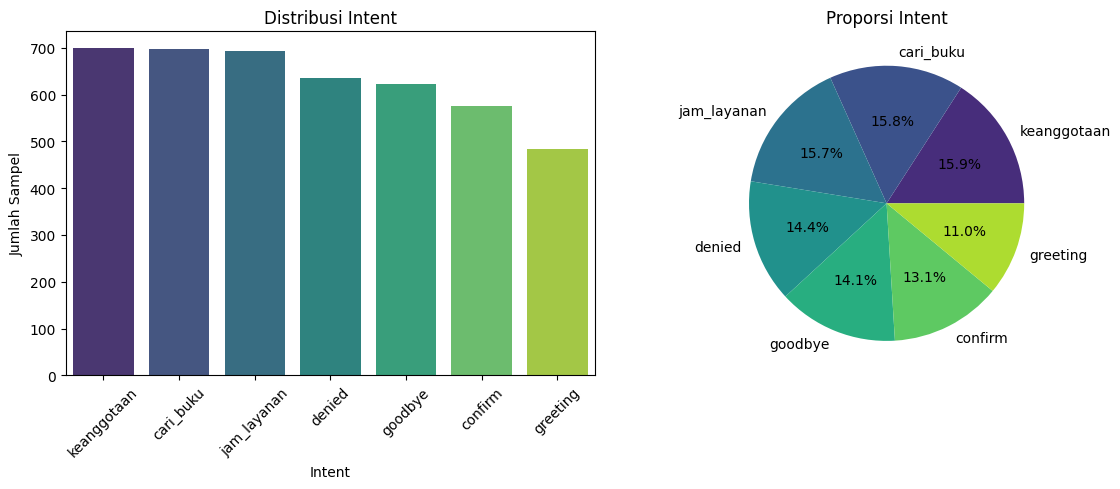


✅ Dataset telah dibagi: 3524 data training dan 882 data validasi
Memuat model IndoBERT...


tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model berhasil dimuat
Menyiapkan dataset...
Menggunakan class weights: [0.90382149 1.09440994 0.99100112 1.01090075 1.30084902 0.90871583
 0.89897959]
Menggunakan device: cuda
Mulai pelatihan model...
Total epoch: 12, batch size: 32, learning rate: 2.5e-05, weight decay: 0.01
Menggunakan Focal Loss dengan gamma=2.0

Epoch 1/12 - Training dimulai...


Epoch 1/12 [Training]:   0%|          | 0/111 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/498M [00:00<?, ?B/s]

Epoch 1/12 - Validasi dimulai...


Epoch 1/12:
  Train Loss: 0.6121
  Val Loss: 0.0527, Val Accuracy: 97.05%
  Val F1: 0.9707, Val Precision: 0.9727, Val Recall: 0.9705

Class-wise precision/recall/F1 setelah epoch 1:
              precision    recall  f1-score   support

           0     0.9929    0.9929    0.9929       140
           1     1.0000    0.8783    0.9352       115
           2     0.9919    0.9685    0.9801       127
           3     0.9308    0.9758    0.9528       124
           4     0.8716    0.9794    0.9223        97
           5     1.0000    0.9928    0.9964       139
           6     0.9929    0.9929    0.9929       140

    accuracy                         0.9705       882
   macro avg     0.9686    0.9686    0.9675       882
weighted avg     0.9727    0.9705    0.9707       882

Menyimpan model terbaik ke /content/drive/MyDrive/RusdiIntents

Epoch 2/12 - Training dimulai...


Epoch 2/12 - Validasi dimulai...


Epoch 2/12:
  Train Loss: 0.0378
  Val Loss: 0.0471, Val Accuracy: 98.41%
  Val F1: 0.9841, Val Precision: 0.9843, Val Recall: 0.9841

Class-wise precision/recall/F1 setelah epoch 2:
              precision    recall  f1-score   support

           0     1.0000    0.9929    0.9964       140
           1     0.9580    0.9913    0.9744       115
           2     0.9695    1.0000    0.9845       127
           3     1.0000    0.9839    0.9919       124
           4     0.9677    0.9278    0.9474        97
           5     1.0000    0.9856    0.9928       139
           6     0.9858    0.9929    0.9893       140

    accuracy                         0.9841       882
   macro avg     0.9830    0.9820    0.9824       882
weighted avg     0.9843    0.9841    0.9841       882

Menyimpan model terbaik ke /content/drive/MyDrive/RusdiIntents

Epoch 3/12 - Training dimulai...


Epoch 3/12 - Validasi dimulai...


Epoch 3/12:
  Train Loss: 0.0105
  Val Loss: 0.0264, Val Accuracy: 99.09%
  Val F1: 0.9909, Val Precision: 0.9910, Val Recall: 0.9909

Class-wise precision/recall/F1 setelah epoch 3:
              precision    recall  f1-score   support

           0     1.0000    0.9929    0.9964       140
           1     0.9744    0.9913    0.9828       115
           2     1.0000    0.9921    0.9960       127
           3     0.9840    0.9919    0.9880       124
           4     0.9688    0.9588    0.9637        97
           5     1.0000    1.0000    1.0000       139
           6     1.0000    1.0000    1.0000       140

    accuracy                         0.9909       882
   macro avg     0.9896    0.9896    0.9896       882
weighted avg     0.9910    0.9909    0.9909       882

Menyimpan model terbaik ke /content/drive/MyDrive/RusdiIntents

Epoch 4/12 - Training dimulai...


Epoch 4/12 - Validasi dimulai...


Epoch 4/12:
  Train Loss: 0.0060
  Val Loss: 0.0284, Val Accuracy: 98.98%
  Val F1: 0.9898, Val Precision: 0.9900, Val Recall: 0.9898

Class-wise precision/recall/F1 setelah epoch 4:
              precision    recall  f1-score   support

           0     1.0000    0.9929    0.9964       140
           1     0.9910    0.9565    0.9735       115
           2     0.9922    1.0000    0.9961       127
           3     0.9612    1.0000    0.9802       124
           4     0.9792    0.9691    0.9741        97
           5     1.0000    1.0000    1.0000       139
           6     1.0000    1.0000    1.0000       140

    accuracy                         0.9898       882
   macro avg     0.9891    0.9884    0.9886       882
weighted avg     0.9900    0.9898    0.9898       882

Validation loss tidak membaik. Early stopping counter: 1/3

Epoch 5/12 - Training dimulai...


Epoch 5/12 - Validasi dimulai...


Epoch 5/12:
  Train Loss: 0.0029
  Val Loss: 0.0234, Val Accuracy: 99.21%
  Val F1: 0.9921, Val Precision: 0.9921, Val Recall: 0.9921

Class-wise precision/recall/F1 setelah epoch 5:
              precision    recall  f1-score   support

           0     1.0000    0.9929    0.9964       140
           1     0.9744    0.9913    0.9828       115
           2     1.0000    0.9921    0.9960       127
           3     0.9841    1.0000    0.9920       124
           4     0.9789    0.9588    0.9688        97
           5     1.0000    1.0000    1.0000       139
           6     1.0000    1.0000    1.0000       140

    accuracy                         0.9921       882
   macro avg     0.9911    0.9907    0.9909       882
weighted avg     0.9921    0.9921    0.9921       882

Menyimpan model terbaik ke /content/drive/MyDrive/RusdiIntents

Epoch 6/12 - Training dimulai...


Epoch 6/12 - Validasi dimulai...


Epoch 6/12:
  Train Loss: 0.0027
  Val Loss: 0.0220, Val Accuracy: 99.21%
  Val F1: 0.9921, Val Precision: 0.9921, Val Recall: 0.9921

Class-wise precision/recall/F1 setelah epoch 6:
              precision    recall  f1-score   support

           0     1.0000    0.9929    0.9964       140
           1     0.9912    0.9826    0.9869       115
           2     0.9845    1.0000    0.9922       127
           3     1.0000    1.0000    1.0000       124
           4     0.9592    0.9691    0.9641        97
           5     1.0000    1.0000    1.0000       139
           6     1.0000    0.9929    0.9964       140

    accuracy                         0.9921       882
   macro avg     0.9907    0.9911    0.9909       882
weighted avg     0.9921    0.9921    0.9921       882

Menyimpan model terbaik ke /content/drive/MyDrive/RusdiIntents

Epoch 7/12 - Training dimulai...


Epoch 7/12 - Validasi dimulai...


Epoch 7/12:
  Train Loss: 0.0014
  Val Loss: 0.0279, Val Accuracy: 99.21%
  Val F1: 0.9920, Val Precision: 0.9921, Val Recall: 0.9921

Class-wise precision/recall/F1 setelah epoch 7:
              precision    recall  f1-score   support

           0     1.0000    0.9929    0.9964       140
           1     0.9744    0.9913    0.9828       115
           2     0.9921    0.9921    0.9921       127
           3     0.9920    1.0000    0.9960       124
           4     0.9789    0.9588    0.9688        97
           5     1.0000    1.0000    1.0000       139
           6     1.0000    1.0000    1.0000       140

    accuracy                         0.9921       882
   macro avg     0.9911    0.9907    0.9909       882
weighted avg     0.9921    0.9921    0.9920       882

Validation loss tidak membaik. Early stopping counter: 1/3

Epoch 8/12 - Training dimulai...


Epoch 8/12 - Validasi dimulai...


Epoch 8/12:
  Train Loss: 0.0011
  Val Loss: 0.0254, Val Accuracy: 99.09%
  Val F1: 0.9909, Val Precision: 0.9910, Val Recall: 0.9909

Class-wise precision/recall/F1 setelah epoch 8:
              precision    recall  f1-score   support

           0     1.0000    0.9929    0.9964       140
           1     0.9744    0.9913    0.9828       115
           2     0.9921    0.9921    0.9921       127
           3     0.9920    1.0000    0.9960       124
           4     0.9688    0.9588    0.9637        97
           5     1.0000    1.0000    1.0000       139
           6     1.0000    0.9929    0.9964       140

    accuracy                         0.9909       882
   macro avg     0.9896    0.9897    0.9896       882
weighted avg     0.9910    0.9909    0.9909       882

Validation loss tidak membaik. Early stopping counter: 2/3

Epoch 9/12 - Training dimulai...


Epoch 9/12 - Validasi dimulai...


Epoch 9/12:
  Train Loss: 0.0008
  Val Loss: 0.0272, Val Accuracy: 99.32%
  Val F1: 0.9932, Val Precision: 0.9932, Val Recall: 0.9932

Class-wise precision/recall/F1 setelah epoch 9:
              precision    recall  f1-score   support

           0     1.0000    0.9929    0.9964       140
           1     0.9828    0.9913    0.9870       115
           2     0.9922    1.0000    0.9961       127
           3     0.9920    1.0000    0.9960       124
           4     0.9789    0.9588    0.9688        97
           5     1.0000    1.0000    1.0000       139
           6     1.0000    1.0000    1.0000       140

    accuracy                         0.9932       882
   macro avg     0.9923    0.9918    0.9920       882
weighted avg     0.9932    0.9932    0.9932       882

Validation loss tidak membaik. Early stopping counter: 3/3
Early stopping triggered setelah 9 epochs
Pelatihan selesai! Model terbaik disimpan di /content/drive/MyDrive/RusdiIntents
Enhanced training history saved to /co

Calibrating OOD detection: 100%|██████████| 56/56 [00:06<00:00,  8.42it/s]


Energy threshold: -5.1050
MSP threshold: 0.8676
OOD thresholds saved at /content/drive/MyDrive/RusdiIntents/ood_thresholds.json


Evaluasi Model: 100%|██████████| 56/56 [00:06<00:00,  8.49it/s]



Model Evaluation Report:
Overall Accuracy: 0.9932
Macro F1-score: 0.9920
Weighted F1-score: 0.9932
Enhanced training history saved to /content/drive/MyDrive/RusdiIntents/enhanced_training_history.json

✅ Model telah berhasil dilatih dan disimpan di /content/drive/MyDrive/RusdiIntents
Jumlah intent: 7
Intent yang didukung: cari_buku, confirm, denied, goodbye, greeting, jam_layanan, keanggotaan
OOD detection thresholds: Energy=-5.1050, MSP=0.8676
Visualisasi training telah disimpan di /content/drive/MyDrive/RusdiIntents
- Interactive plots dapat dibuka pada file HTML di folder tersebut
- Static plots tersedia dalam format PNG
OOD thresholds loaded: Energy=-5.1050, MSP=0.8676
Menggunakan metode deteksi OOD: combined

Demo Prediksi Intent dengan Enhanced OOD Detection:

Mode Interaktif - Masukkan teks untuk prediksi intent
Ketik 'exit' untuk keluar
----------------------------

Masukkan teks: halo permisi saya pengen jadi anggota
✓ Intent terdeteksi: keanggotaan (confidence: 0.9420)

Top 

In [15]:
# Cell 13: Jalankan pipeline (uncomment untuk menjalankan)

model, tokenizer, intent_classes, label_encoder = run_full_pipeline_enhanced(
    use_drive=True,
    percentile=90,
    ood_method='combined',
    split_dataset="yes",
    val_split=0.20,
    batch_size=32,
    epochs=12,
    learning_rate=2.5e-5,
    weight_decay=0.01,
    patience=3,
    train_csv_path="train.csv",
    val_csv_path="val.csv"
)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


=== Classification Report ===
              precision    recall  f1-score   support

   cari_buku       1.00      1.00      1.00        77
     confirm       0.97      1.00      0.99        68
      denied       1.00      0.97      0.99        73
     goodbye       0.99      1.00      0.99        68
    greeting       1.00      0.98      0.99        64
 jam_layanan       1.00      1.00      1.00        78
 keanggotaan       1.00      1.00      1.00        94

    accuracy                           0.99       522
   macro avg       0.99      0.99      0.99       522
weighted avg       0.99      0.99      0.99       522



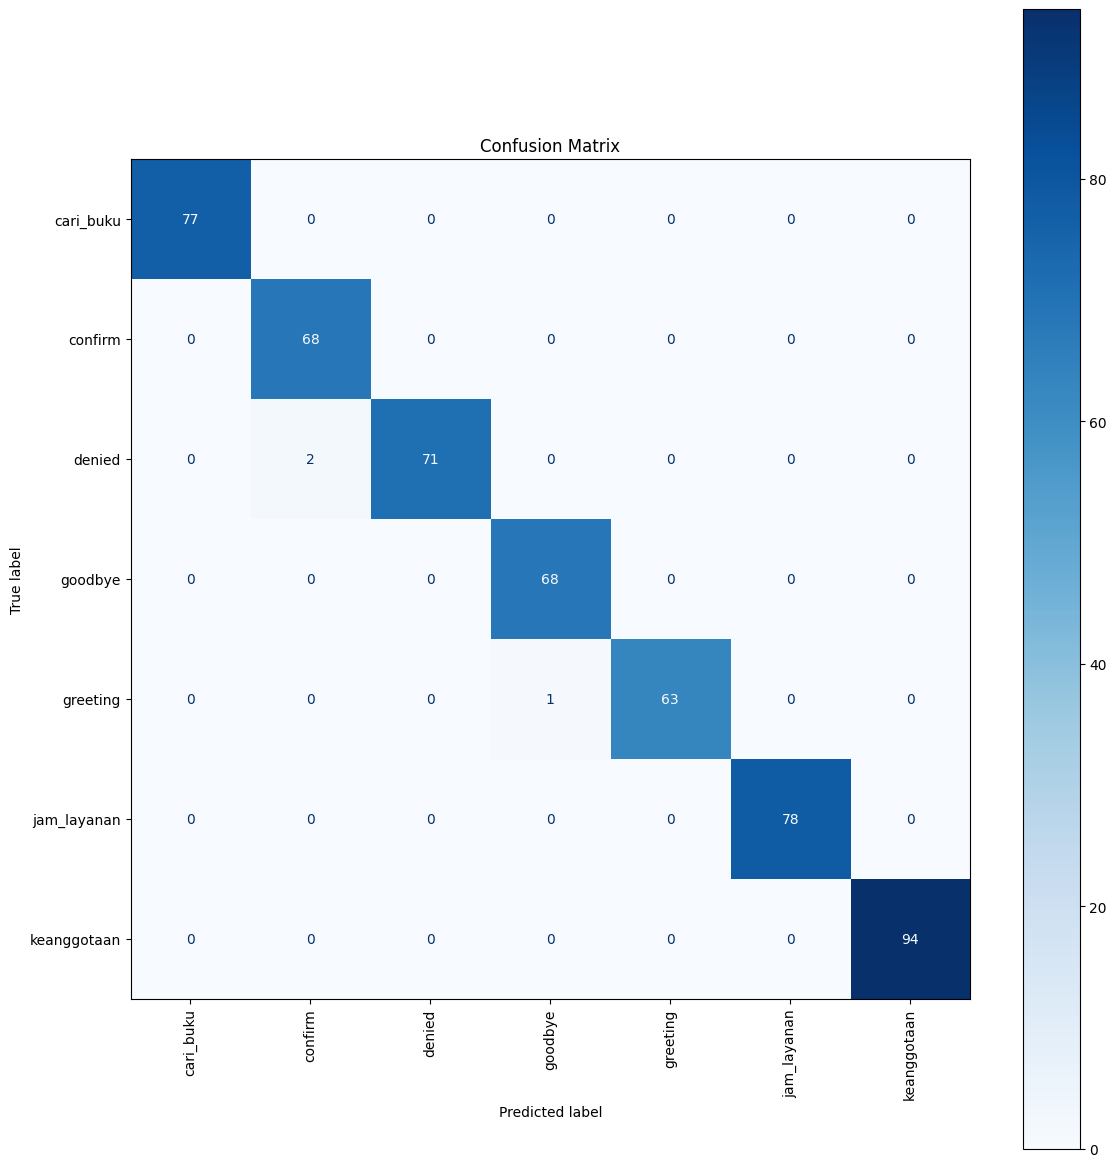

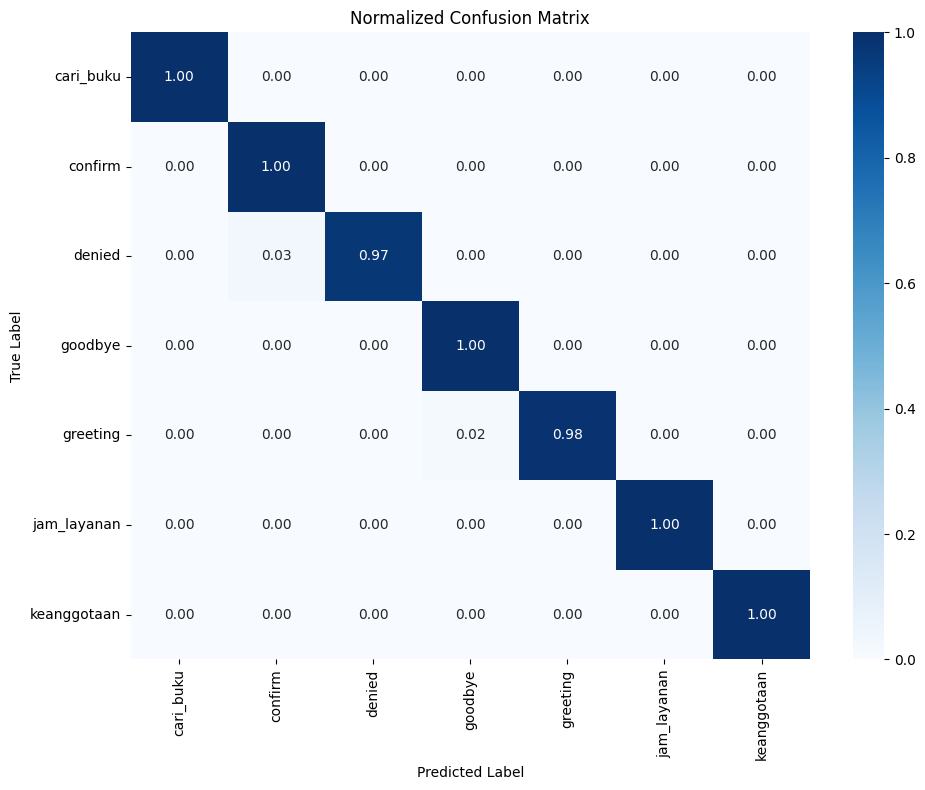

Saved 3 misclassified examples to /content/drive/MyDrive/RusdiIntents/misclassified_examples.csv


In [19]:
# @title Test Set
import pandas as pd
import torch
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle

# ==== Step 1: Load test data ====
test_df = pd.read_csv('test.csv')
test_texts = test_df['text'].tolist()
y_true = test_df['intent'].tolist()  # Assuming the true labels column is named 'intent'
# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(MODEL_SAVE_PATH)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(MODEL_SAVE_PATH)
# ==== Step 2: Load label encoder and intent_classes ====
with open(f"{MODEL_SAVE_PATH}/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)
with open(f"{MODEL_SAVE_PATH}/intent_classes.pkl", "rb") as f: # Load intent_classes
    intent_classes = pickle.load(f)

# Encode the ground truth labels into numerical format
y_true_encoded = label_encoder.transform(y_true)

# ==== Step 3: Define prediction function ====
def get_model_predictions(texts):
    model.eval()
    predictions = []
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    for text in texts:
        inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True).to(device)
        with torch.no_grad():  # Important to avoid unnecessary gradient calculations
            outputs = model(**inputs)
            probs = outputs.logits.softmax(dim=1)
            pred = probs.argmax(dim=1).item()
            predictions.append(pred)
    return predictions

# ==== Step 4: Get predictions ====
y_pred = get_model_predictions(test_texts)
y_pred_labels = [intent_classes[i] for i in y_pred]

# ==== Step 5: Print Classification Report ====
print("=== Classification Report ===")
print(classification_report(y_true, y_pred_labels, target_names=intent_classes))

# ==== Step 6: Confusion Matrix (encoded labels for alignment) ====
cm = confusion_matrix(y_true_encoded, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=intent_classes)

# ==== Step 7: Plot Confusion Matrix ====
fig, ax = plt.subplots(figsize=(12, 12))
disp.plot(xticks_rotation='vertical', ax=ax, cmap='Blues')
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(10, 8))
sns.heatmap(cm_normalized, annot=True, cmap="Blues", xticklabels=intent_classes, yticklabels=intent_classes, fmt=".2f")
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# Create a list to store misclassified examples
misclassified_examples = []

for i, (true, pred_idx, text) in enumerate(zip(y_true_encoded, y_pred, test_texts)):
    if true != pred_idx:
        misclassified_examples.append({
            'text': text,
            'true_label': intent_classes[true],
            'predicted_label': intent_classes[pred_idx]
        })

# Save misclassified examples to CSV
if misclassified_examples:
    misclassified_df = pd.DataFrame(misclassified_examples)
    misclassified_csv_path = f"{MODEL_SAVE_PATH}/misclassified_examples.csv"
    misclassified_df.to_csv(misclassified_csv_path, index=False)
    print(f"Saved {len(misclassified_examples)} misclassified examples to {misclassified_csv_path}")
else:
    print("No misclassified examples found.")



In [20]:
# @title Teks judul default
test_sentences = [
    # GREETING
    "Halo, selamat pagi!",
    "Apa kabar?",
    "Hai, bot!",
    "Permisi, boleh bertanya?",
    "Yo, ada orang di sana?",

    # GOODBYE
    "Terima kasih, sampai jumpa.",
    "Ok, saya pergi dulu.",
    "Sampai nanti!",
    "Dadah, bot.",
    "Aku akan kembali nanti.",

    # CONFIRM
    "Iya, benar.",
    "Betul sekali.",
    "Ya, saya setuju.",
    "Tentu saja.",
    "Itu yang saya maksud.",

    # DENIED
    "Tidak, bukan itu.",
    "Salah.",
    "Bukan, maksud saya yang lain.",
    "Enggak.",
    "Saya tidak yakin dengan itu.",

    # AMBIGUOUS (bisa mengecoh)
    "Saya rasa tidak perlu, tapi ya juga boleh.",
    "Mungkin... tapi entahlah.",
    "Terserah kamu aja deh.",
    "Boleh iya, boleh juga tidak.",
    "Ya tapi tidak juga sih...",
    "p",
    "test",
    "y",
    "g",
    "N"
]


In [ ]:
# @title Teks judul default
# If you want to load an existing model and run predictions
run_prediction_demo_enhanced( #model, tokenizer, intent_classes, label_encoder, method=ood_method
    model_path=MODEL_SAVE_PATH,  # Your MODEL_SAVE_PATH
    method='combined',  # Which OOD detection method to use
    test_texts=test_sentences
)

In [ ]:
# @title Dataset Augmentation for Indonesian NLP
import pandas as pd
import random
import re
import nltk
import torch
import time
import os
import matplotlib.pyplot as plt
from nltk.corpus import wordnet
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from deep_translator import GoogleTranslator
from collections import defaultdict, Counter
from tqdm import tqdm

# Download WordNet data (if not already downloaded)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# =========[ KONFIGURASI ]=========
INPUT_FILE = "/content/custom_test_dataset.csv"  # @param {type:"string"} Bisa CSV atau XLSX
DATA_TYPE = "test" # @param ["train", "val", "test"]
TARGET_SAMPLES_PER_CLASS = 100    # @param {type:"integer"} Target jumlah sampel per kelas
USE_PARAPHRASE_MODEL = True       # @param {type:"boolean"} Aktifkan atau matikan paraphrase
USE_BACK_TRANSLATION = False       # @param {type:"boolean"} Aktifkan atau matikan back-translation
MIN_AUGMENTATIONS_PER_SAMPLE = 0  # @param {type:"integer"} Minimum augmentasi per sampel asli
MAX_AUGMENTATIONS_PER_SAMPLE = 10  # @param {type:"integer"} Maximum augmentasi per sampel asli
BATCH_SIZE = 16                   # @param {type:"integer"} Untuk batch processing

# =========[ IMPROVED SYNONYM DICTIONARY ]=========
# Kamus sinonim Indonesia untuk kata-kata umum
id_synonyms = {
    # Kata-kata terkait sapaan
    "saya": ["aku", "gue", "gua", "hamba", "beta"],
    "kamu": ["anda", "engkau", "kalian", "elu", "dikau"],
    "hai": ["halo", "hello", "hi", "hey", "hola"],
    "selamat": ["slamat", "met", "congratz"],
    "pagi": ["morning", "subuh"],
    "siang": ["dzuhur", "sore"],
    "malam": ["malem", "night"],

    # Kata-kata umum
    "tidak": ["tak", "tiada", "bukan", "enggak", "nggak", "gak", "kagak"],
    "iya": ["ya", "yoi", "yup", "yo", "oke", "ok", "betul"],
    "bagaimana": ["gimana", "bagaimane", "gmn", "bgmn"],
    "mengapa": ["kenapa", "knp", "knapa", "ngapa"],
    "karena": ["sebab", "lantaran", "gara-gara"],
    "sangat": ["banget", "amat", "sekali", "sungguh"],
    "bisa": ["dapat", "mampu", "sanggup"],
    "mungkin": ["barangkali", "kali", "kayaknya", "kayanya"],
    "terima kasih": ["makasih", "tks", "thx", "thanks", "tengkyu", "tengkiu"],
    "tolong": ["bantu", "bantuin", "tlg", "help"],
    "mau": ["ingin", "pengen", "berkenan"],
    "pergi": ["berangkat", "cabut", "start", "jalan"],
    "lihat": ["tengok", "liat", "ngeliat", "mantau"],
    "cari": ["mencari", "nyari", "telusuri"]
}

# =========[ INTENT-SPECIFIC SLANG DICTIONARIES ]=========
# Kata gaul umum untuk semua intent
common_slang = {
    'tidak': 'gak',
    'iya': 'yoi',
    'terima kasih': 'makasih',
    'saya': 'gw',
    'kamu': 'lo',
    'sedang': 'lagi',
    'bagaimana': 'gimana',
    'begitu': 'gitu',
    'bisa': 'bsa',
    'akan': 'bakal',
    'untuk': 'buat',
    'tahu': 'tau',
    'apakah': 'apa',
    'mengapa': 'kenapa',
    'selamat': 'selamet',
    'dengan': 'dgn',
    'sangat': 'banget',
    'nigga': 'nigger',
    'coy': 'coek'
}

# Kamus kata gaul khusus intent
intent_slang = {
    'jam_layanan': {
        'perpustakaan': 'perpus',
        'buka': 'open',
        'tutup': 'close',
        'sampai': 'sampe',
        'jam': 'jm',
        'informasi': 'info',
        'hari ini': 'hr ini',
        'kapan': 'kpn',
        'jadwal': 'jdwl',
        'operasional': 'ops',
        'layanan': 'lyn',
        'masih': 'msih',
        'minggu': 'mg',
        'hari': 'hri',
        'pukul': 'pkl',
    },
    'cari_buku': {
        'mencari': 'nyari',
        'mau mencari': 'mau nyari',
        'ingin mencari': 'pengen nyari',
        'tolong carikan': 'cariin',
        'tolong bantu cari': 'bantuin cari',
        'mencarikan': 'cariin',
        'buku': 'book',
        'butuh': 'need',
        'melihat': 'liat',
        'daftar': 'list',
        'akses': 'akses',
        'temukan': 'nemu',
        'mencoba': 'nyoba',
        'mengakses': 'akses',
        'gunakan': 'make use',
        'fitur': 'fitr',
        'pencarian': 'search',
        'referensi': 'ref',
        'bantuan': 'bntuan',
        'dimana': 'dmn',
        'cek': 'check',
        'lihat-lihat': 'liat2',
        'cari': 'search',
        'mencari buku': 'nyari book',
    },
    'greeting': {
        'halo': 'haloo',
        'hai': 'hay',
        'hello': 'helo',
        'selamat pagi': 'slmt pagi',
        'selamat siang': 'slmt siang',
        'selamat sore': 'slmt sore',
        'selamat malam': 'slmt malam',
        'apa kabar': 'apa kbr',
        'assalamualaikum': 'asswrwb',
        'permisi': 'permizz',
        'hai bot': 'hey bot',
        'bot': 'bt',
        'selamat datang': 'slmt dtg',
        # Additional variations for greeting
        'halo selamat pagi': 'hai morning',
        'hai selamat siang': 'helo siang',
        'met pagi': 'morning',
        'pagi': 'pgi',
        'siang': 'siang boss',
    },
    'goodbye': {
        'terima kasih': 'makasih',
        'goodbye': 'gudbai',
        'makasih': 'mksh',
        'makasih ya': 'thx ya',
        'sampai jumpa': 'sampe jmpa',
        'dadah': 'daah',
        'bye': 'byee',
        'sampai nanti': 'sampe ntar',
        'see you': 'cu',
        'thanks': 'thx',
        'thank you': 'tq',
        'sekian': 'skian',
        'itu saja': 'itu aj',
        # Additional variations for goodbye
        'ok makasih': 'ok thx',
        'terima kasih banyak': 'thanks banget',
        'makasih atas bantuannya': 'thx for helping',
        'sampai bertemu lagi': 'see u later',
        'selamat tinggal': 'bye bye',
    },
    'confirm': {
        'betul': 'btl',
        'setuju': 'stju',
        'bener': 'bnr',
        'iya benar': 'ya bnr',
        'okey': 'okeyy',
        'ok deh': 'okedeh',
        # Additional variations for confirm
        'tentu saja': 'tentu',
        'saya setuju': 'aku setuju',
        'benar sekali': 'bener banget',
        'ya betul': 'yup betul',
        'tentu boleh': 'boleh dong',
        'setuju sekali': 'sangat setuju',
    },
    'denied': {
        'tidak mau': 'gak mau',
        'ga mau': 'gk mw',
        'tidak setuju': 'gak setuju',
        'saya tidak': 'aku ga',
        'nggak perlu': 'ga perlu',
        'ga usah': 'rasah',
        'tidak perlu': 'gak usah',
        'no': 'nope',
        # Additional variations for denied
        'saya tidak setuju': 'aku gak setuju',
        'tidak bisa': 'ga bisa',
        'tidak boleh': 'gak boleh',
        'jangan': 'jgn',
        'maaf tidak': 'sorry no',
        'tidak begitu': 'gak gitu',
    }
}

# =========[ PHONETIC AUGMENTATION DICTIONARY ]=========
phonetic_dict = {
        # Greeting related
        "saya": ["sy", "saia", "ane", "ana", "w", "gw", "q", "aq"],
        "kamu": ["km", "kamyu", "u", "lo", "lu", "l", "ngana", "sampeyan", "antum", "ente"],
        "halo": ["hlo", "hallo", "helo", "haloo", "hellow", "hy", "hyy", "p", "ping"],
        "selamat": ["slmt", "slamat", "met", "slam"],
        "pagi": ["pgi", "morning", "pg", "subuh"],
        "siang": ["siang", "afternoon", "siank", "siyang"],
        "malam": ["mlm", "malem", "mlem", "night", "evening", "mlem", "mlm"],
        "apa": ["ap", "ape", "apah", "pa"],
        "kabar": ["kbr", "kabare", "kbar", "kabbar"],
        "gimana": ["gmn", "bgmn", "gmana", "gimane", "gmn"],

        # Goodbye related
        "sampai": ["smp", "sampe", "smpe", "smpei", "sampeyan"],
        "jumpa": ["jpa", "jmpa", "ktmu", "jumpe"],
        "dadah": ["byebye", "bye", "bay", "byee", "bbye", "bye2", "dadah"],
        "pamit": ["pmt", "pamitt", "off", "out", "cabut", "cbut"],
        "tinggal": ["tgl", "tnggal", "tinggel", "tggal", "tinggelin"],
        "duluan": ["dlu", "duluan", "dluan", "dluan ya", "ahead"],
        "pergi": ["pgi", "pegi", "prgi", "out", "keluar"],
        "pulang": ["plg", "plng", "balik", "blk", "mudik"],

        # Confirm related
        "ya": ["y", "yah", "iye", "yoi", "yups", "yes", "yess", "yesss", "okey", "okeh", "oks"],
        "setuju": ["stju", "acc", "accept", "approved", "approve", "deal", "oke", "ok", "sip"],
        "benar": ["bnr", "bner", "bener", "bnr", "yoi", "correct"],
        "sudah": ["sdh", "dah", "udh", "done", "wes", "uwes", "udah", "sdah"],
        "bisa": ["bs", "bsa", "biza", "bsa", "biza", "ok"],
        "pasti": ["pst", "psti", "pastii", "sure", "certain"],
        "siap": ["sp", "ready", "sip", "sp", "roger", "on", "online"],
        "jadi": ["jd", "jdi", "jdnya", "jdiin", "proceed"],
        "lanjut": ["lnjt", "lanjt", "next", "go"],
        "mantap": ["mntap", "mantab", "mntb", "top", "mantul", "josss", "kerennn"],
        "bagus": ["bgs", "bgus", "nice", "naiss", "keren", "top"],

        # Denied related
        "tidak": ["tdk", "gak", "ga", "g", "nggak", "ngga", "nope", "no", "kagak", "kaga", "kgk"],
        "jangan": ["jgn", "jngn", "don't", "dont", "jgn", "ga usah", "tdk usah", "gausa", "gausah"],
        "belum": ["blm", "blom", "belom", "not yet", "durung", "durong", "belm"],
        "batal": ["btl", "cancel", "cansel", "urungkan", "batalin", "gajadi"],
        "maaf": ["sorry", "sori", "maf", "maap", "maaaaf", "mrff", "sry", "srry"],
        "menolak": ["tlk", "reject", "decline", "dtolak", "nolak", "gak mau", "gamau"],
        "mustahil": ["impossible", "ga mungkin", "g mungkin", "tdk mungkin", "gak bs"],
        "salah": ["slh", "wrong", "error", "eror", "salh", "fail"],
        "gagal": ["ggl", "fail", "failed", "error", "gagak", "failll"],

        # Common words
        "terima": ["trma", "thanks", "thx", "trims", "tq", "tyvm", "makasih", "mksih"],
        "kasih": ["ksh", "ksih", "thx", "makasih", "mksih", "thanks"],
        "tolong": ["tlng", "help", "tlg", "tulung", "bantu", "bantuin"],
        "please": ["plz", "plis", "pliss", "plisss", "pliissss", "tolong"],
        "besok": ["bsk", "bsok", "besok", "tmrw", "esok", "besuk"],
        "waktu": ["wkt", "waktu", "time", "tm", "jam"],
        "cukup": ["ckp", "enough", "cukuppp", "cukups", "ckup"],
        "melihat": ["lihat", "liat", "look", "see", "watching", "ngeliat"],
        "alasan": ["alsan", "reason", "why", "alesan", "alsn"],
        "untuk": ["utk", "buat", "bwt", "4", "tuk", "2", "to"],
        "melakukan": ["lakukan", "do", "lakuin", "melakuin", "ngerjain"],
        "ini": ["ni", "this", "these", "iki", "nih", "ne"],
        "kita": ["kta", "we", "us", "w", "kt"],
        "hari": ["hr", "day", "hri", "days", "dayy", "harii"],
        "bro": ["broh", "brow", "brother", "mas", "bang", "bor", "omm"],
        "sis": ["sist", "sister", "mbak", "mba", "nte", "ceu", "teh"]
    }

# =========[ READ & VALIDATE FILE ]=========
def read_dataset(file_path):
    """Membaca dataset dari file CSV atau XLSX"""
    print(f"Loading dataset: {file_path}")

    file_ext = os.path.splitext(file_path)[1].lower()

    if file_ext == '.xlsx':
        print(f"Detected Excel file: {file_path}")
        df = pd.read_excel(file_path)
        # Konversi ke CSV untuk kompatibilitas
        csv_path = file_path.replace('.xlsx', '.csv')
        df.to_csv(csv_path, index=False)
        print(f"Converted Excel file to CSV: {csv_path}")
    elif file_ext == '.csv':
        print(f"Detected CSV file: {file_path}")
        df = pd.read_csv(file_path)
    else:
        raise ValueError(f"Format file tidak didukung: {file_ext}. Harap gunakan file CSV atau XLSX.")

    df = df.dropna()
    print(f"Dataset dimuat dengan {len(df)} baris")

    return df

# =========[ INITIALIZE PARAPHRASE MODEL IF NEEDED ]=========
def initialize_paraphrase_model():
    """Initialize paraphrase model if enabled"""
    if USE_PARAPHRASE_MODEL:
        print("Loading paraphrase model...")
        start_time = time.time()
        tokenizer = AutoTokenizer.from_pretrained("Wikidepia/IndoT5-base-paraphrase")
        model = AutoModelForSeq2SeqLM.from_pretrained("Wikidepia/IndoT5-base-paraphrase")

        # Move model to GPU if available
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        print(f"Model loaded in {time.time() - start_time:.2f} seconds. Using device: {device}")
        return model, tokenizer
    return None, None

# =========[ AUGMENTATION METHODS ]=========
def get_better_synonym(word):
    """Get synonym from custom dictionary or return the original word"""
    word_lower = word.lower()
    if word_lower in id_synonyms:
        synonyms = id_synonyms[word_lower]
        return random.choice(synonyms)
    return word

def replace_with_synonym(sentence):
    """Replace words with synonyms while preserving capitalization"""
    words = sentence.split()
    new_words = []

    for word in words:
        synonym = get_better_synonym(word)
        # Preserve capitalization
        if word and word[0].isupper() and synonym:
            synonym = synonym[0].upper() + synonym[1:]
        new_words.append(synonym)

    return " ".join(new_words)

def back_translate(sentence):
    """Translate to English and back to Indonesian"""
    if not USE_BACK_TRANSLATION:
        return sentence

    try:
        # First to English
        translated = GoogleTranslator(source='id', target='en').translate(sentence)
        # Then back to Indonesian
        back_translated = GoogleTranslator(source='en', target='id').translate(translated)

        # Only return if result is different but not completely unrelated
        if back_translated != sentence and len(back_translated.split()) >= len(sentence.split()) * 0.5:
            return back_translated
        return sentence
    except Exception:
        return sentence

def add_typo(sentence):
    """Add a single typo by replacing a character"""
    chars = list(sentence)
    if len(chars) > 3:
        idx = random.randint(0, len(chars) - 1)
        if chars[idx].isalpha():  # Only replace letters
            chars[idx] = random.choice("abcdefghijklmnopqrstuvwxyz")
    return "".join(chars)

def random_deletion(sentence, p=0.2):
    """Delete words with probability p"""
    words = sentence.split()
    if len(words) <= 3:  # Don't delete from very short sentences
        return sentence

    new_words = []
    for word in words:
        if random.uniform(0, 1) > p:
            new_words.append(word)

    # Make sure we don't delete everything
    if not new_words:
        return sentence

    return " ".join(new_words)

def random_swap(sentence, n=1):
    """Swap n pairs of words"""
    words = sentence.split()
    if len(words) < 2:
        return sentence

    for _ in range(min(n, len(words)//2)):  # Ensure we don't try too many swaps
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]

    return " ".join(words)

def phonetic_augmentation(sentence):
    """Apply phonetic substitutions common in Indonesian chat"""
    words = sentence.split()
    new_words = []

    for word in words:
        word_lower = word.lower()
        if word_lower in phonetic_dict:
            new_word = random.choice(phonetic_dict[word_lower])
            # Preserve capitalization
            if word and word[0].isupper():
                new_word = new_word[0].upper() + new_word[1:]
            new_words.append(new_word)
        else:
            new_words.append(word)

    return " ".join(new_words)

def apply_slang_typo(text, intent, intensity=1.0):
    """Apply slang replacements with controllable intensity"""
    # Combine common slang with intent-specific slang
    slang_dict = common_slang.copy()
    if intent in intent_slang:
        slang_dict.update(intent_slang[intent])

    # Create regex patterns from the slang dictionary
    patterns = {
        re.compile(rf'\b{k}\b', re.IGNORECASE): v for k, v in slang_dict.items()
    }

    # Apply only some of the patterns based on intensity
    patterns_to_use = random.sample(
        list(patterns.items()),
        k=int(len(patterns) * min(1.0, intensity * 0.7))
    )

    for pattern, replacement in patterns_to_use:
        text = pattern.sub(replacement, text)

    return text

def character_noise(text, intensity=1.0):
    """Add typos like character swaps, insertions, deletions"""
    chars = list(text)
    swap_prob = min(0.1, intensity * 0.05)  # Scale probability with intensity

    # Character swaps
    for i in range(len(chars)-1):
        if random.random() < swap_prob:
            chars[i], chars[i+1] = chars[i+1], chars[i]

    return ''.join(chars)

def add_common_phrase(sentence):
    """Add a common Indonesian chat phrase"""
    common_phrases = ["sih", "ya", "dong", "cuy", "bro", "lah", "plis", "eh",
                    "nih", "gitu", "kan", "yah", "deh", "banget"]
    return sentence + " " + random.choice(common_phrases)

def short_text_augmentation(text, intent):
    """Special augmentation for very short texts like greetings and goodbyes"""
    # For very short texts, add filler words or expressions
    fillers = {
        'greeting': ['', ' ya', ' kak', ' min', ' gan', ' bro', ' sis', ' admin', '!', '!!'],
        'goodbye': ['', ' ya', ' kak', ' min', ' sekali lagi', ' semuanya', '!', '!!'],
        'confirm': ['', ' kok', ' dong', ' banget', ' sih', ' tentu', ' lah', '!', '!!'],
        'denied': ['', ' sih', ' kok', ' ah', ' deh', ' lah', '!', '!!'],
    }

    if intent in fillers and len(text.split()) <= 3:
        # Add 0-2 random fillers
        num_fillers = random.randint(0, 2)
        for _ in range(num_fillers):
            text += random.choice(fillers[intent])

    return text

def validate_augmentation(original, augmented):
    """Validate if augmentation is reasonable"""
    # Check if augmentation is too different
    if len(augmented.split()) < len(original.split()) * 0.5:
        return False

    # Check if augmentation is just the original
    if augmented.lower() == original.lower():
        return False

    # Check if augmentation contains too many non-Indonesian characters
    non_indo_pattern = re.compile(r'[^a-zA-Z0-9\s.,?!\'"-:;()[\]{}]')
    if len(non_indo_pattern.findall(augmented)) > 2:
        return False

    return True

def batch_paraphrase(model, tokenizer, sentences, batch_size=BATCH_SIZE):
    """Process paraphrasing in batches"""
    if not sentences or model is None or tokenizer is None:
        return []

    device = next(model.parameters()).device
    results = []

    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        inputs = tokenizer(["paraphrase: " + text + " </s>" for text in batch],
                         padding='longest', truncation=True, max_length=128,
                         return_tensors="pt").to(device)

        with torch.no_grad():  # Disable gradient calculation for inference
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=128,
                do_sample=True,
                top_k=200,
                top_p=0.95,
                early_stopping=True,
                num_return_sequences=1
            )

        decoded = [tokenizer.decode(outputs[j], skip_special_tokens=True)
                  for j in range(len(outputs))]
        results.extend(decoded)

    return results

# Combined augmentation strategies
def augment_text(text, intent, intensity=1.0):
    """Apply multiple augmentation techniques based on class needs"""
    # Available methods
    methods = {
        'synonym': replace_with_synonym,
        'back_translate': back_translate,
        'typo': add_typo,
        'deletion': random_deletion,
        'swap': random_swap,
        'phonetic': phonetic_augmentation,
        'common_phrase': add_common_phrase,
        'slang': lambda t: apply_slang_typo(t, intent, intensity),
        'char_noise': lambda t: character_noise(t, intensity),
        'short_text': lambda t: short_text_augmentation(t, intent)
    }

    # Choose augmentation methods based on text length and intent
    text_length = len(text.split())

    if text_length <= 3:  # Very short text
        # For short texts, focus on slang and special augmentations
        method_choices = ['slang', 'slang', 'phonetic', 'short_text', 'char_noise', 'synonym']
        num_methods = min(3, int(intensity * 3))
    else:  # Longer text
        method_choices = ['slang', 'synonym', 'phonetic', 'back_translate', 'deletion', 'swap', 'char_noise', 'common_phrase']
        num_methods = min(3, int(intensity * 2))

    # Sample methods
    selected_methods = random.sample(method_choices, k=num_methods)

    # Apply selected methods in sequence
    result = text
    for method_name in selected_methods:
        method = methods[method_name]
        result = method(result)

    return result

def augment_data(text, intent):
    """Generate multiple augmentations for a text"""
    methods = [
        replace_with_synonym,
        back_translate,
        add_typo,
        random_deletion,
        random_swap,
        phonetic_augmentation,
        add_common_phrase,
        lambda t: apply_slang_typo(t, intent, 1.0),
        lambda t: character_noise(t, 1.0),
        lambda t: short_text_augmentation(t, intent)
    ]

    augmented = set()
    for method in methods:
        try:
            result = method(text)
            if validate_augmentation(text, result):
                augmented.add(result)
        except Exception as e:
            print(f"Error applying {method.__name__}: {str(e)}")
            continue

    return list(augmented)

def balance_samples(results_by_intent, target_samples_per_class, original_counts):
    """
    Balance samples by intent, ensuring a good mix of original and augmented data:
    1. Keep all original samples
    2. Add augmentations until target is reached
    3. Limit excess samples if over target
    """
    balanced_results = defaultdict(list)

    # For each intent
    for intent, samples in results_by_intent.items():
        # Count of original samples for this intent
        orig_count = original_counts.get(intent, 0)

        # Current total count
        current_count = len(samples)

        if current_count <= target_samples_per_class:
            # If sample count is below target, use all samples
            balanced_results[intent] = samples
        else:
            # If over target, balance original vs augmented
            # Ensure we keep all original data (priority)
            original_data = samples[:orig_count]

            # Add original data
            balanced_results[intent].extend(original_data)

            # Calculate how many augmented samples we can add
            remaining_slots = target_samples_per_class - orig_count

            if remaining_slots > 0:
                # Get augmented samples (everything after original data)
                augmented_data = samples[orig_count:]
                # Randomize selection
                random.shuffle(augmented_data)
                # Add only what we need to reach target
                balanced_results[intent].extend(augmented_data[:remaining_slots])

    return balanced_results

def plot_distribution(data, title):
    """Plot distribution of samples by intent"""
    plt.figure(figsize=(10, 5))
    data['intent'].value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel("Intent")
    plt.ylabel("Jumlah Sampel")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# =========[ MAIN PROCESS ]=========
def main():
    """Main process for dataset augmentation"""
    # Set up file paths based on chosen data type
    if DATA_TYPE == "train":
        OUTPUT_FILE = "train.csv"
        input_file = INPUT_FILE
        output_file = OUTPUT_FILE
    elif DATA_TYPE == "val":
        # If different paths needed for validation
        OUTPUT_FILE = "val.csv"
        input_file = INPUT_FILE.replace("train", "val")
        output_file = OUTPUT_FILE.replace("train", "val")
    elif DATA_TYPE == "test":
        # If different paths needed for test
        OUTPUT_FILE = "test.csv"
        input_file = INPUT_FILE.replace("train", "test")
        output_file = OUTPUT_FILE.replace("train", "test")
    else:
        input_file = INPUT_FILE
        output_file = OUTPUT_FILE

    # Read the dataset
    df = read_dataset(input_file)

    # Initialize paraphrase model if enabled
    model, tokenizer = initialize_paraphrase_model()

    # Count original samples per intent
    intent_counts = Counter(df['intent'])
    print("Original class distribution:")
    for intent, count in intent_counts.items():
        print(f"  {intent}: {count}")

    # Calculate augmentation factors for balancing
    augmentation_factors = {}
    for intent, count in intent_counts.items():
        if count >= TARGET_SAMPLES_PER_CLASS:
            augmentation_factors[intent] = 1  # Minimum factor
        else:
            factor = max(1, min(10, TARGET_SAMPLES_PER_CLASS / count))
            augmentation_factors[intent] = factor

    print("\nAugmentation factors:")
    for intent, factor in augmentation_factors.items():
        print(f"  {intent}: {factor:.2f}x")

    # Start augmentation process
    print("Starting balanced augmentation...")
    start_time = time.time()

    augmented_results = defaultdict(list)
    paraphrase_candidates = defaultdict(list)

    # First, add all original data
    for _, row in df.iterrows():
        intent = row['intent']
        text = row['text']
        augmented_results[intent].append(text)

    # Then determine augmentation targets for each intent
    for intent, factor in augmentation_factors.items():
        original_count = intent_counts[intent]
        intent_df = df[df['intent'] == intent]

        for _, row in tqdm(intent_df.iterrows(), desc=f"Augmenting '{intent}'", total=len(intent_df)):
            text = row['text']

            # Calculate needed augmentations for this sample
            num_augmentations = max(
                MIN_AUGMENTATIONS_PER_SAMPLE,
                min(MAX_AUGMENTATIONS_PER_SAMPLE, int(factor * 2))
            )

            # Regular augmentations
            for _ in range(num_augmentations):
                # Higher intensity for smaller classes
                intensity = 1.0 + (factor - 1) * 0.5  # Scale 1.0-5.0 based on factor
                aug_text = augment_text(text, intent, intensity)

                if aug_text.lower() != text.lower():
                    augmented_results[intent].append(aug_text)

            # Add sample for paraphrasing if enabled
            if USE_PARAPHRASE_MODEL and model is not None:
                # More paraphrasing for under-represented classes
                paraphrase_prob = min(0.8, factor * 0.2)
                if random.random() < paraphrase_prob:
                    paraphrase_candidates[intent].append(text)

    # Process paraphrases in batches by intent
    if USE_PARAPHRASE_MODEL and model is not None:
        for intent, sentences in paraphrase_candidates.items():
            if not sentences:
                continue

            print(f"Paraphrasing {len(sentences)} sentences for intent '{intent}'...")
            paraphrased = batch_paraphrase(model, tokenizer, sentences)

            # Add paraphrased results
            for original, paraphrase in zip(sentences, paraphrased):
                if original.lower() != paraphrase.lower():
                    augmented_results[intent].append(paraphrase)

    # Balance class distribution
    print("Balancing class distribution...")
    balanced_results = balance_samples(augmented_results, TARGET_SAMPLES_PER_CLASS, intent_counts)

    # Combine all results
    final_results = []
    for intent, texts in balanced_results.items():
        for text in texts:
            final_results.append((intent, text))

    # Save results
    print("Final class distribution:")
    result_counts = defaultdict(int)
    for intent, _ in final_results:
        result_counts[intent] += 1

    for intent, count in result_counts.items():
        print(f"  {intent}: {count}")

    aug_df = pd.DataFrame(final_results, columns=['intent', 'text'])
    aug_df.drop_duplicates(subset=['text'], keep='first', inplace=True)
    aug_df.to_csv(output_file, index=False)

    print(f"[✓] Selesai dalam {time.time() - start_time:.2f} detik!")
    print(f"Original: {len(df)} | Total setelah augmentasi: {len(aug_df)} → {output_file}")

    # Plot distributions
    print("\n📊 Distribusi Sebelum Augmentasi:")
    df_original = df[['text', 'intent']]
    plot_distribution(df_original, "Distribusi Intent Sebelum Augmentasi")

    print("\n📊 Distribusi Setelah Augmentasi:")
    plot_distribution(aug_df, "Distribusi Intent Setelah Augmentasi (Seimbang)")

if __name__ == "__main__":
    main()

Loading dataset: /content/custom_test_dataset.csv
Detected CSV file: /content/custom_test_dataset.csv
Dataset dimuat dengan 70 baris
Loading paraphrase model...
Model loaded in 2.51 seconds. Using device: cuda
Original class distribution:
  greeting: 10
  confirm: 10
  denied: 10
  goodbye: 10
  jam_layanan: 10
  cari_buku: 10
  keanggotaan: 10

Augmentation factors:
  greeting: 10.00x
  confirm: 10.00x
  denied: 10.00x
  goodbye: 10.00x
  jam_layanan: 10.00x
  cari_buku: 10.00x
  keanggotaan: 10.00x
Starting balanced augmentation...


Augmenting 'keanggotaan': 100%|██████████| 10/10 [00:14<00:00,  1.47s/it]



Applying paraphrase model in batches...
  Processing 4 texts for intent 'greeting'
    Added 0 valid paraphrases
  Processing 2 texts for intent 'confirm'
    Added 0 valid paraphrases
  Processing 2 texts for intent 'denied'
    Added 1 valid paraphrases
  Processing 6 texts for intent 'goodbye'
    Added 0 valid paraphrases
  Processing 2 texts for intent 'jam_layanan'
    Added 0 valid paraphrases
  Processing 5 texts for intent 'cari_buku'
    Added 0 valid paraphrases
  Processing 1 texts for intent 'keanggotaan'
    Added 1 valid paraphrases
Balancing final dataset...

Final dataset statistics:
  greeting: 229 total (10 original + 219 augmented)
  confirm: 229 total (10 original + 219 augmented)
  denied: 229 total (10 original + 219 augmented)
  goodbye: 229 total (10 original + 219 augmented)
  jam_layanan: 229 total (10 original + 219 augmented)
  cari_buku: 229 total (10 original + 219 augmented)
  keanggotaan: 229 total (10 original + 219 augmented)

Saved balanced dataset 

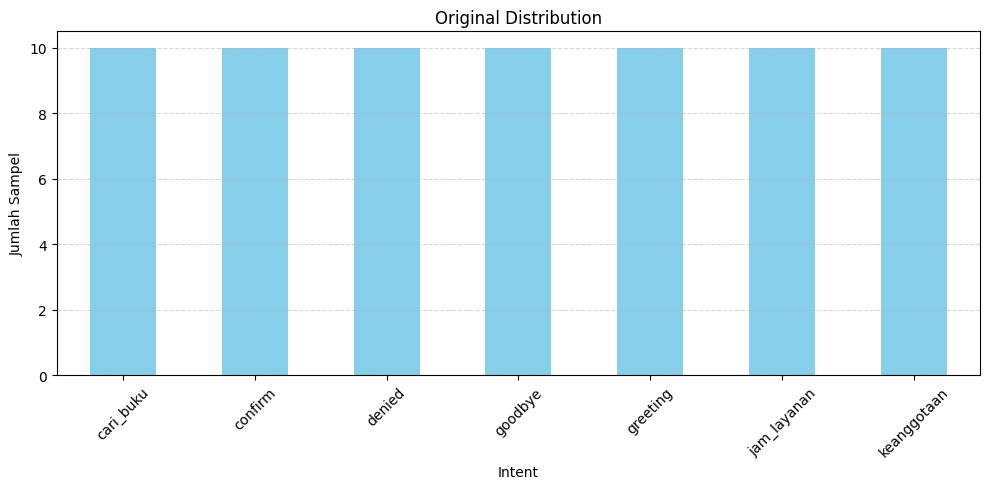

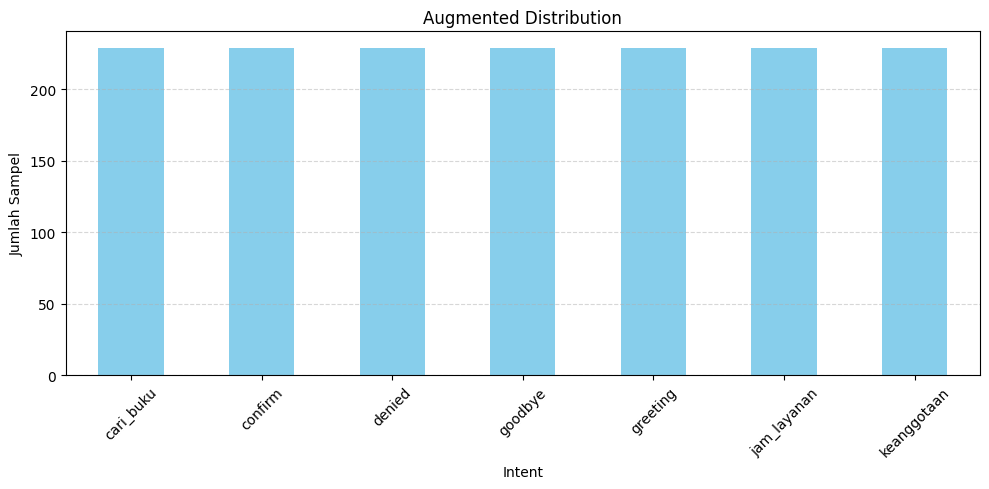


Summary:
  Original samples: 70
  Final samples: 1603
  Added samples: 1533
  Augmentation ratio: 22.90x
  Processing time: 98.69 seconds


In [17]:
# @title Dataset Augmentation for Indonesian NLP - Improved Version
import pandas as pd
import random
import re
import nltk
import torch
import time
import os
import matplotlib.pyplot as plt
from nltk.corpus import wordnet
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from deep_translator import GoogleTranslator
from collections import defaultdict, Counter
from tqdm import tqdm
import Levenshtein as lev  # For better text difference calculation

# Download WordNet data (if not already downloaded)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)

# =========[ KONFIGURASI ]=========
INPUT_FILE = "/content/custom_test_dataset.csv" # @param {"type":"string"}
DATA_TYPE = "test" # @param ["train", "val", "test"]
TARGET_SAMPLES_PER_CLASS = 250    # @param {type:"integer"} Target jumlah sampel per kelas
NOISE_INTENSITY = 0.7             # @param {type:"number"} Control how aggressive augmentations are (0.1-1.0)
USE_PARAPHRASE_MODEL = True       # @param {type:"boolean"} Aktifkan atau matikan paraphrase
USE_BACK_TRANSLATION = True       # @param {type:"boolean"} Aktifkan atau matikan back-translation
MIN_AUGMENTATIONS_PER_SAMPLE = 1  # @param {type:"integer"} Minimum augmentasi per sampel asli
MAX_AUGMENTATIONS_PER_SAMPLE = 10  # @param {type:"integer"} Maximum augmentasi per sampel asli (reduced from 10)
BATCH_SIZE = 16                   # @param {type:"integer"} Untuk batch processing

# =========[ IMPROVED SYNONYM DICTIONARY ]=========
# Kamus sinonim Indonesia untuk kata-kata umum
id_synonyms = {
    # Kata-kata terkait sapaan
    "saya": ["aku", "gue", "gua", "hamba", "beta"],
    "kamu": ["anda", "engkau", "kalian", "elu", "dikau"],
    "hai": ["halo", "hello", "hi", "hey", "hola"],
    "selamat": ["slamat", "met", "congratz"],
    "pagi": ["morning", "subuh"],
    "siang": ["dzuhur", "sore"],
    "malam": ["malem", "night"],

    # Kata-kata umum
    "tidak": ["tak", "tiada", "bukan", "enggak", "nggak", "gak", "kagak"],
    "iya": ["ya", "yoi", "yup", "yo", "oke", "ok", "betul"],
    "bagaimana": ["gimana", "bagaimane", "gmn", "bgmn"],
    "mengapa": ["kenapa", "knp", "knapa", "ngapa"],
    "karena": ["sebab", "lantaran", "gara-gara"],
    "sangat": ["banget", "amat", "sekali", "sungguh"],
    "bisa": ["dapat", "mampu", "sanggup"],
    "mungkin": ["barangkali", "kali", "kayaknya", "kayanya"],
    "terima kasih": ["makasih", "tks", "thx", "thanks", "tengkyu", "tengkiu"],
    "tolong": ["bantu", "bantuin", "tlg", "help"],
    "mau": ["ingin", "pengen", "berkenan"],
    "pergi": ["berangkat", "cabut", "start", "jalan"],
    "lihat": ["tengok", "liat", "ngeliat", "mantau"],
    "cari": ["mencari", "nyari", "telusuri"]
}

# =========[ INTENT-SPECIFIC SLANG DICTIONARIES ]=========
# Kata gaul umum untuk semua intent
common_slang = {
    'tidak': 'gak',
    'iya': 'yoi',
    'terima kasih': 'makasih',
    'saya': 'gw',
    'kamu': 'lo',
    'sedang': 'lagi',
    'bagaimana': 'gimana',
    'begitu': 'gitu',
    'bisa': 'bsa',
    'akan': 'bakal',
    'untuk': 'buat',
    'tahu': 'tau',
    'apakah': 'apa',
    'mengapa': 'kenapa',
    'selamat': 'selamet',
    'dengan': 'dgn',
    'sangat': 'banget'
}

# Kamus kata gaul khusus intent
intent_slang = {
    'jam_layanan': {
        'perpustakaan': 'perpus',
        'buka': 'open',
        'tutup': 'close',
        'sampai': 'sampe',
        'jam': 'jm',
        'informasi': 'info',
        'hari ini': 'hr ini',
        'kapan': 'kpn',
        'jadwal': 'jdwl',
        'operasional': 'ops',
        'layanan': 'lyn',
        'masih': 'msih',
        'minggu': 'mg',
        'hari': 'hri',
        'pukul': 'pkl',
    },
    'cari_buku': {
        'mencari': 'nyari',
        'mau mencari': 'mau nyari',
        'ingin mencari': 'pengen nyari',
        'tolong carikan': 'cariin',
        'tolong bantu cari': 'bantuin cari',
        'mencarikan': 'cariin',
        'buku': 'book',
        'butuh': 'need',
        'melihat': 'liat',
        'daftar': 'list',
        'akses': 'akses',
        'temukan': 'nemu',
        'mencoba': 'nyoba',
        'mengakses': 'akses',
        'gunakan': 'make use',
        'fitur': 'fitr',
        'pencarian': 'search',
        'referensi': 'ref',
        'bantuan': 'bntuan',
        'dimana': 'dmn',
        'cek': 'check',
        'lihat-lihat': 'liat2',
        'cari': 'search',
        'mencari buku': 'nyari book',
    },
    'greeting': {
        'halo': 'haloo',
        'hai': 'hay',
        'hello': 'helo',
        'selamat pagi': 'slmt pagi',
        'selamat siang': 'slmt siang',
        'selamat sore': 'slmt sore',
        'selamat malam': 'slmt malam',
        'apa kabar': 'apa kbr',
        'assalamualaikum': 'asswrwb',
        'permisi': 'permizz',
        'hai bot': 'hey bot',
        'bot': 'bt',
        'selamat datang': 'slmt dtg',
        # Additional variations for greeting
        'halo selamat pagi': 'hai morning',
        'hai selamat siang': 'helo siang',
        'met pagi': 'morning',
        'pagi': 'pgi',
        'siang': 'siang boss',
    },
    'goodbye': {
        'terima kasih': 'makasih',
        'goodbye': 'gudbai',
        'makasih': 'mksh',
        'makasih ya': 'thx ya',
        'sampai jumpa': 'sampe jmpa',
        'dadah': 'daah',
        'bye': 'byee',
        'sampai nanti': 'sampe ntar',
        'see you': 'cu',
        'thanks': 'thx',
        'thank you': 'tq',
        'sekian': 'skian',
        'itu saja': 'itu aj',
        # Additional variations for goodbye
        'ok makasih': 'ok thx',
        'terima kasih banyak': 'thanks banget',
        'makasih atas bantuannya': 'thx for helping',
        'sampai bertemu lagi': 'see u later',
        'selamat tinggal': 'bye bye',
    },
    'confirm': {
        'betul': 'btl',
        'setuju': 'stju',
        'bener': 'bnr',
        'iya benar': 'ya bnr',
        'okey': 'okeyy',
        'ok deh': 'okedeh',
        # Additional variations for confirm
        'tentu saja': 'tentu',
        'saya setuju': 'aku setuju',
        'benar sekali': 'bener banget',
        'ya betul': 'yup betul',
        'tentu boleh': 'boleh dong',
        'setuju sekali': 'sangat setuju',
    },
    'denied': {
        'tidak mau': 'gak mau',
        'ga mau': 'gk mw',
        'tidak setuju': 'gak setuju',
        'saya tidak': 'aku ga',
        'nggak perlu': 'ga perlu',
        'ga usah': 'rasah',
        'tidak perlu': 'gak usah',
        'no': 'nope',
        # Additional variations for denied
        'saya tidak setuju': 'aku gak setuju',
        'tidak bisa': 'ga bisa',
        'tidak boleh': 'gak boleh',
        'jangan': 'jgn',
        'maaf tidak': 'sorry no',
        'tidak begitu': 'gak gitu',
    },
    'keanggotaan': {
        'anggota': 'anggta',
        'keanggotaan': 'member',
        'daftar': 'dftr',
        'pendaftaran': 'daftarin',
        'syarat': 'req',
        'jadi anggota': 'jd member',
        'mendaftar': 'daftar',
        'mahasiswa': 'mhs',
        'kampus': 'uni',
        'kartu mahasiswa': 'ktm',
        'aktif': 'aktif',
        'foto': 'poto',
        'pas foto': 'pasfoto',
        'perpustakaan': 'perpus',
        'bisa jadi anggota': 'bs jd member',
        'boleh daftar': 'boleh gabung',
        'bawa apa': 'bwa apa',
        'tunjukin apa': 'tunjuk apa',
        'masuk perpustakaan': 'akses perpus',
        'pakai fasilitas': 'gunain fasilitas',
        'kampus lain': 'dari luar',
        'dari luar': 'bukan bina patria',
        'akses fasilitas': 'pakai fasilitas',
        'pakai perpus': 'akses perpus',
        'baca di tempat': 'bca di tmpt',
        'bisa baca': 'bs bca',
        'pinjam buku': 'minjem book',
        'mahasiswa luar': 'mhs luar',
        'harus bawa': 'hrus bwa',
    }
}

# =========[ PHONETIC AUGMENTATION DICTIONARY ]=========
phonetic_dict = {
        # Greeting related
        "saya": ["sy", "saia", "ane", "ana", "w", "gw", "q", "aq"],
        "kamu": ["km", "kamyu", "u", "lo", "lu", "l", "ngana", "sampeyan", "antum", "ente"],
        "halo": ["hlo", "hallo", "helo", "haloo", "hellow", "hy", "hyy", "p", "ping"],
        "selamat": ["slmt", "slamat", "met", "slam"],
        "pagi": ["pgi", "morning", "pg", "subuh"],
        "siang": ["siang", "afternoon", "siank", "siyang"],
        "malam": ["mlm", "malem", "mlem", "night", "evening", "mlem", "mlm"],
        "apa": ["ap", "ape", "apah", "pa"],
        "kabar": ["kbr", "kabare", "kbar", "kabbar"],
        "gimana": ["gmn", "bgmn", "gmana", "gimane", "gmn"],

        # Goodbye related
        "sampai": ["smp", "sampe", "smpe", "smpei", "sampeyan"],
        "jumpa": ["jpa", "jmpa", "ktmu", "jumpe"],
        "dadah": ["byebye", "bye", "bay", "byee", "bbye", "bye2", "dadah"],
        "pamit": ["pmt", "pamitt", "off", "out", "cabut", "cbut"],
        "tinggal": ["tgl", "tnggal", "tinggel", "tggal", "tinggelin"],
        "duluan": ["dlu", "duluan", "dluan", "dluan ya", "ahead"],
        "pergi": ["pgi", "pegi", "prgi", "out", "keluar"],
        "pulang": ["plg", "plng", "balik", "blk", "mudik"],

        # Confirm related
        "ya": ["y", "yah", "iye", "yoi", "yups", "yes", "yess", "yesss", "okey", "okeh", "oks"],
        "setuju": ["stju", "acc", "accept", "approved", "approve", "deal", "oke", "ok", "sip"],
        "benar": ["bnr", "bner", "bener", "bnr", "yoi", "correct"],
        "sudah": ["sdh", "dah", "udh", "done", "wes", "uwes", "udah", "sdah"],
        "bisa": ["bs", "bsa", "biza", "bsa", "biza", "ok"],
        "pasti": ["pst", "psti", "pastii", "sure", "certain"],
        "siap": ["sp", "ready", "sip", "sp", "roger", "on", "online"],
        "jadi": ["jd", "jdi", "jdnya", "jdiin", "proceed"],
        "lanjut": ["lnjt", "lanjt", "next", "go"],
        "mantap": ["mntap", "mantab", "mntb", "top", "mantul", "josss", "kerennn"],
        "bagus": ["bgs", "bgus", "nice", "naiss", "keren", "top"],

        # Denied related
        "tidak": ["tdk", "gak", "ga", "g", "nggak", "ngga", "nope", "no", "kagak", "kaga", "kgk"],
        "jangan": ["jgn", "jngn", "don't", "dont", "jgn", "ga usah", "tdk usah", "gausa", "gausah"],
        "belum": ["blm", "blom", "belom", "not yet", "durung", "durong", "belm"],
        "batal": ["btl", "cancel", "cansel", "urungkan", "batalin", "gajadi"],
        "maaf": ["sorry", "sori", "maf", "maap", "maaaaf", "mrff", "sry", "srry"],
        "menolak": ["tlk", "reject", "decline", "dtolak", "nolak", "gak mau", "gamau"],
        "mustahil": ["impossible", "ga mungkin", "g mungkin", "tdk mungkin", "gak bs"],
        "salah": ["slh", "wrong", "error", "eror", "salh", "fail"],
        "gagal": ["ggl", "fail", "failed", "error", "gagak", "failll"],

        # Common words
        "terima": ["trma", "thanks", "thx", "trims", "tq", "tyvm", "makasih", "mksih"],
        "kasih": ["ksh", "ksih", "thx", "makasih", "mksih", "thanks"],
        "tolong": ["tlng", "help", "tlg", "tulung", "bantu", "bantuin"],
        "please": ["plz", "plis", "pliss", "plisss", "pliissss", "tolong"],
        "besok": ["bsk", "bsok", "besok", "tmrw", "esok", "besuk"],
        "waktu": ["wkt", "waktu", "time", "tm", "jam"],
        "cukup": ["ckp", "enough", "cukuppp", "cukups", "ckup"],
        "melihat": ["lihat", "liat", "look", "see", "watching", "ngeliat"],
        "alasan": ["alsan", "reason", "why", "alesan", "alsn"],
        "untuk": ["utk", "buat", "bwt", "4", "tuk", "2", "to"],
        "melakukan": ["lakukan", "do", "lakuin", "melakuin", "ngerjain"],
        "ini": ["ni", "this", "these", "iki", "nih", "ne"],
        "kita": ["kta", "we", "us", "w", "kt"],
        "hari": ["hr", "day", "hri", "days", "dayy", "harii"],
        "bro": ["broh", "brow", "brother", "mas", "bang", "bor", "omm"],
        "sis": ["sist", "sister", "mbak", "mba", "nte", "ceu", "teh"]
    }

# =========[ PROTECTED WORDS BY INTENT ]=========
# Words that should not be altered for each intent to preserve meaning
protected_intent_words = {
    'jam_layanan': ['jam', 'buka', 'tutup', 'perpustakaan', 'layanan', 'kapan', 'bipa', 'bina patria'],
    'cari_buku': ['buku', 'cari', 'judul', 'penulis', 'isbn', 'kategori', 'bipa', 'bina patria'],
    'greeting': ['halo', 'hai', 'selamat', 'pagi', 'siang', 'malam'],
    'goodbye': ['selamat', 'tinggal', 'sampai', 'jumpa', 'terima', 'kasih'],
    'confirm': ['iya', 'betul', 'benar', 'setuju', 'ok'],
    'denied': ['tidak', 'bukan', 'salah', 'jangan'],
    'keanggotaan': [
        'anggota', 'keanggotaan', 'daftar', 'pendaftaran', 'syarat',
        'mahasiswa', 'kampus', 'kartu mahasiswa', 'aktif', 'foto', 'pas foto',
        'perpustakaan', 'akses', 'fasilitas', 'pinjam', 'baca', 'bipa', 'bina patria'
    ]
}



# =========[ READ & VALIDATE FILE ]=========
def read_dataset(file_path):
    """Membaca dataset dari file CSV atau XLSX"""
    print(f"Loading dataset: {file_path}")

    file_ext = os.path.splitext(file_path)[1].lower()

    if file_ext == '.xlsx':
        print(f"Detected Excel file: {file_path}")
        df = pd.read_excel(file_path)
        # Konversi ke CSV untuk kompatibilitas
        csv_path = file_path.replace('.xlsx', '.csv')
        df.to_csv(csv_path, index=False)
        print(f"Converted Excel file to CSV: {csv_path}")
    elif file_ext == '.csv':
        print(f"Detected CSV file: {file_path}")
        df = pd.read_csv(file_path)
    else:
        raise ValueError(f"Format file tidak didukung: {file_ext}. Harap gunakan file CSV atau XLSX.")

    df = df.dropna()
    print(f"Dataset dimuat dengan {len(df)} baris")

    return df

# =========[ INITIALIZE PARAPHRASE MODEL IF NEEDED ]=========
def initialize_paraphrase_model():
    """Initialize paraphrase model if enabled"""
    if USE_PARAPHRASE_MODEL:
        print("Loading paraphrase model...")
        start_time = time.time()
        tokenizer = AutoTokenizer.from_pretrained("Wikidepia/IndoT5-base-paraphrase")
        model = AutoModelForSeq2SeqLM.from_pretrained("Wikidepia/IndoT5-base-paraphrase")

        # Move model to GPU if available
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model = model.to(device)
        print(f"Model loaded in {time.time() - start_time:.2f} seconds. Using device: {device}")
        return model, tokenizer
    return None, None

# =========[ AUGMENTATION METHODS ]=========
def get_better_synonym(word):
    """Get synonym from custom dictionary or return the original word"""
    word_lower = word.lower()
    if word_lower in id_synonyms:
        synonyms = id_synonyms[word_lower]
        return random.choice(synonyms)
    return word

def replace_with_synonym(sentence):
    """Replace words with synonyms while preserving capitalization"""
    words = sentence.split()
    new_words = []

    # Limit the number of words to replace to avoid excessive changes
    num_to_replace = min(2, max(1, int(len(words) * 0.2)))
    indices_to_replace = random.sample(range(len(words)), k=min(num_to_replace, len(words)))

    for i, word in enumerate(words):
        if i in indices_to_replace:
            synonym = get_better_synonym(word)
            # Preserve capitalization
            if word and word[0].isupper() and synonym:
                synonym = synonym[0].upper() + synonym[1:]
            new_words.append(synonym)
        else:
            new_words.append(word)

    return " ".join(new_words)

def back_translate(sentence):
    """Translate to English and back to Indonesian with safety checks"""
    if not USE_BACK_TRANSLATION:
        return sentence

    # Skip very short sentences
    if len(sentence.split()) < 3:
        return sentence

    try:
        # First to English
        translated = GoogleTranslator(source='id', target='en').translate(sentence)
        # Then back to Indonesian
        back_translated = GoogleTranslator(source='en', target='id').translate(translated)

        # Safety checks
        if back_translated and len(back_translated.split()) >= len(sentence.split()) * 0.7:
            # Calculate how different the result is
            similarity = 1 - (lev.distance(sentence.lower(), back_translated.lower()) / max(len(sentence), len(back_translated)))
            # If too different or too similar, return original
            if similarity < 0.3 or similarity > 0.9:
                return sentence
            return back_translated
        return sentence
    except Exception:
        return sentence

def add_typo(sentence):
    """Add a single typo by replacing a character, with reduced probability"""
    # Skip for very short sentences or with low global noise setting
    if len(sentence) < 10 or random.random() > NOISE_INTENSITY:
        return sentence

    chars = list(sentence)
    if len(chars) > 3:
        # Try to find a good character to modify (not first or last character)
        candidates = [i for i in range(1, len(chars)-1) if chars[i].isalpha()]
        if candidates:
            idx = random.choice(candidates)
            # Get neighboring letters on keyboard for more realistic typos
            keyboard_neighbors = {
                'q': 'wsa', 'w': 'qeasd', 'e': 'wrsdf', 'r': 'etdfg',
                't': 'ryfgh', 'y': 'tughj', 'u': 'yihjk', 'i': 'uojkl',
                'o': 'ipkl', 'p': 'ol',
                'a': 'qwszx', 's': 'awedcxz', 'd': 'serfcvx', 'f': 'drtgvbc',
                'g': 'ftyhvbn', 'h': 'gyujbnm', 'j': 'huiknm', 'k': 'jiolm',
                'l': 'kop',
                'z': 'asx', 'x': 'zsdc', 'c': 'xdfv', 'v': 'cfgb',
                'b': 'vghn', 'n': 'bhjm', 'm': 'njk'
            }
            char = chars[idx].lower()
            if char in keyboard_neighbors:
                chars[idx] = random.choice(keyboard_neighbors[char])

    return "".join(chars)

def random_deletion(sentence, p=0.1):  # Reduced probability from 0.2
    """Delete words with probability p"""
    words = sentence.split()

    # Don't delete from short sentences
    if len(words) <= 4:
        return sentence

    # Don't delete too many words
    max_deletions = max(1, int(len(words) * 0.1))
    deletion_count = 0

    new_words = []
    for word in words:
        if random.uniform(0, 1) > p or deletion_count >= max_deletions:
            new_words.append(word)
        else:
            deletion_count += 1

    # Make sure we don't delete everything
    if not new_words:
        return sentence

    return " ".join(new_words)

def random_swap(sentence, n=1):
    """Swap n pairs of words"""
    words = sentence.split()
    if len(words) < 4:  # Don't swap in very short sentences
        return sentence

    # Limit swaps to just 1 for shorter sentences
    if len(words) < 8:
        n = 1

    for _ in range(min(n, len(words)//3)):  # Reduced number of swaps
        idx1, idx2 = random.sample(range(len(words)), 2)
        words[idx1], words[idx2] = words[idx2], words[idx1]

    return " ".join(words)

def phonetic_augmentation(sentence):
    """Apply phonetic substitutions common in Indonesian chat"""
    words = sentence.split()
    new_words = []

    # Limit substitutions to maintain readability
    max_substitutions = min(2, max(1, int(len(words) * 0.2)))
    substitution_count = 0

    for word in words:
        word_lower = word.lower()
        if word_lower in phonetic_dict and substitution_count < max_substitutions:
            new_word = random.choice(phonetic_dict[word_lower])
            # Preserve capitalization
            if word and word[0].isupper():
                new_word = new_word[0].upper() + new_word[1:]
            new_words.append(new_word)
            substitution_count += 1
        else:
            new_words.append(word)

    return " ".join(new_words)

def apply_slang_typo(text, intent, intensity=1.0):
    """Apply slang replacements with controllable intensity"""
    # Combine common slang with intent-specific slang
    slang_dict = common_slang.copy()
    if intent in intent_slang:
        slang_dict.update(intent_slang[intent])

    # Create regex patterns from the slang dictionary
    patterns = {
        re.compile(rf'\b{k}\b', re.IGNORECASE): v for k, v in slang_dict.items()
    }

    # Apply only a few patterns based on intensity and text length
    max_replacements = min(2, max(1, int(len(text.split()) * 0.2)))
    patterns_to_use = random.sample(
        list(patterns.items()),
        k=min(max_replacements, int(len(patterns) * min(0.3, intensity * 0.5)))
    )

    for pattern, replacement in patterns_to_use:
        text = pattern.sub(replacement, text)

    return text

def character_noise(text, intensity=1.0):
    """Add typos like character swaps, insertions, deletions with reduced intensity"""
    # Skip for very short texts
    if len(text) < 10 or random.random() > NOISE_INTENSITY:
        return text

    chars = list(text)
    # Significantly reduce swap probability
    swap_prob = min(0.03, intensity * 0.01)  # Lower from 0.1 to 0.03

    # Limit to just one or two swaps per sentence
    max_swaps = min(1, int(len(chars) * 0.05))
    swap_count = 0

    for i in range(len(chars)-1):
        if random.random() < swap_prob and swap_count < max_swaps:
            # Don't swap punctuation or spaces
            if chars[i].isalpha() and chars[i+1].isalpha():
                chars[i], chars[i+1] = chars[i+1], chars[i]
                swap_count += 1

    return ''.join(chars)

def add_common_phrase(sentence):
    """Add a common Indonesian chat phrase"""
    # Skip for longer sentences
    if len(sentence.split()) > 8:
        return sentence

    common_phrases = ["sih", "ya", "dong", "cuy", "bro", "lah", "deh"]
    return sentence + " " + random.choice(common_phrases)

def short_text_augmentation(text, intent):
    """Special augmentation for very short texts like greetings and goodbyes"""
    # For very short texts, add filler words or expressions
    fillers = {
        'greeting': ['', ' ya', ' kak', ' min', ' gan', ' bro', ' sis', ' admin', '!'],
        'goodbye': ['', ' ya', ' kak', ' min', ' semuanya', '!'],
        'confirm': ['', ' kok', ' dong', ' banget', ' sih', ' tentu', ' lah', '!'],
        'denied': ['', ' sih', ' kok', ' ah', ' deh', ' lah', '!'],
    }

    if intent in fillers and len(text.split()) <= 3:
        # Add just one filler
        if random.random() < 0.7:  # 70% chance to add filler
            text += random.choice(fillers[intent])

    return text

def validate_augmentation(original, augmented):
    """Validate if augmentation is reasonable with stricter requirements"""
    # Skip if no change
    if augmented.lower() == original.lower():
        return False

    # Calculate word count difference
    orig_words = original.split()
    aug_words = augmented.split()

    # Check if length is reasonable
    if len(aug_words) < len(orig_words) * 0.6 or len(aug_words) > len(orig_words) * 1.4:
        return False

    # Calculate text similarity using Levenshtein distance
    normalized_distance = lev.distance(original.lower(), augmented.lower()) / max(len(original), len(augmented))
    # If too similar or too different, reject
    if normalized_distance < 0.03 or normalized_distance > 0.5:
        return False

    # Check for excessive non-standard characters
    non_indo_pattern = re.compile(r'[^a-zA-Z0-9\s.,?!\'"-:;()[\]{}]')
    if len(non_indo_pattern.findall(augmented)) > 3:
        return False

    # Check if individual words have been mangled too much
    if len(orig_words) == len(aug_words):
        word_changes = 0
        for i in range(len(orig_words)):
            # Check word edit distance
            if len(orig_words[i]) > 3 and lev.distance(orig_words[i], aug_words[i]) > len(orig_words[i]) * 0.5:
                word_changes += 1

        # Reject if too many words changed significantly
        if word_changes / len(orig_words) > 0.4:
            return False

    return True

def batch_paraphrase(model, tokenizer, sentences, batch_size=BATCH_SIZE):
    """Process paraphrasing in batches"""
    if not sentences or model is None or tokenizer is None:
        return []

    device = next(model.parameters()).device
    results = []

    for i in range(0, len(sentences), batch_size):
        batch = sentences[i:i+batch_size]
        inputs = tokenizer(["paraphrase: " + text + " </s>" for text in batch],
                         padding='longest', truncation=True, max_length=128,
                         return_tensors="pt").to(device)

        with torch.no_grad():  # Disable gradient calculation for inference
            outputs = model.generate(
                input_ids=inputs["input_ids"],
                attention_mask=inputs["attention_mask"],
                max_length=128,
                do_sample=True,
                top_k=200,  # Reduce from 200 to 120 for more conservative output
                top_p=0.98,
                temperature=NOISE_INTENSITY + 0.3, # Added temperature control
                early_stopping=False,
                num_return_sequences=min(3, BATCH_SIZE // len(batch))
            )

        decoded = [tokenizer.decode(outputs[j], skip_special_tokens=True)
                  for j in range(len(outputs))]
        results.extend(decoded)

    return results

# Combined augmentation strategies
def augment_text(text, intent, intensity=1.0):
    """Apply multiple augmentation techniques based on class needs"""
    # Scale intensity by global noise setting
    intensity = intensity * NOISE_INTENSITY

    # Protect intent-critical words
    protected = []
    if intent in protected_intent_words:
        for word in protected_intent_words[intent]:
            pattern = re.compile(rf'\b{word}\b', re.IGNORECASE)
            for match in pattern.finditer(text):
                # Replace with a temporary placeholder
                placeholder = f"__PROTECTED_{len(protected)}__"
                text = text[:match.start()] + placeholder + text[match.end():]
                protected.append((placeholder, match.group(0)))

    # Available methods - reorder by safety
    methods = {
        'synonym': replace_with_synonym,          # Safe
        'back_translate': back_translate if USE_BACK_TRANSLATION else None,  # Generally safe
        'slang': lambda t: apply_slang_typo(t, intent, intensity), # Safe if using known slang
        'common_phrase': add_common_phrase,       # Safe
        'short_text': lambda t: short_text_augmentation(t, intent), # Safe
        'swap': random_swap,                      # Moderately safe
        'deletion': random_deletion,              # Can be problematic
        'phonetic': phonetic_augmentation,        # Can be problematic
        'char_noise': lambda t: character_noise(t, intensity * 0.5),  # Reduced intensity
        'typo': add_typo                          # Most problematic
    }

    # Remove None methods
    methods = {k: v for k, v in methods.items() if v is not None}

    # Choose augmentation methods based on text length and intent
    text_length = len(text.split())

    if text_length <= 3:  # Very short text
        # For short texts, focus on safer methods
        method_choices = ['slang', 'short_text', 'synonym', 'common_phrase']
        num_methods = min(2, int(intensity * 2))  # Reduce number of transformations
    else:  # Longer text
        # Weight safer methods higher in the selection
        method_choices = ['synonym', 'synonym', 'back_translate', 'slang', 'slang',
                          'common_phrase', 'swap', 'deletion', 'phonetic', 'char_noise']
        # Apply fewer transformations overall
        num_methods = min(2, int(intensity * 1.5))

    # Filter out any methods that aren't available (like back_translate if disabled)
    method_choices = [m for m in method_choices if m in methods]

    # Sample methods
    if method_choices:
        selected_methods = random.sample(method_choices, k=min(num_methods, len(method_choices)))
    else:
        selected_methods = []

    # Apply selected methods in sequence
    result = text
    for method_name in selected_methods:
        if method_name in methods:
            method = methods[method_name]
            result = method(result)

    # Restore protected words
    for placeholder, original in protected:
        result = result.replace(placeholder, original)

    return result

def augment_data(text, intent):
    """Generate multiple augmentations for a text"""
    methods = [
        replace_with_synonym,
        back_translate if USE_BACK_TRANSLATION else None,
        lambda t: augment_text(t, intent, 1.0)  # Use combined approach
    ]

    # Remove None methods
    methods = [m for m in methods if m is not None]

    augmented = set()
    for method in methods:
        try:
            result = method(text)
            if validate_augmentation(text, result):
                augmented.add(result)
        except Exception as e:
            print(f"Error applying {method.__name__}: {str(e)}")
            continue

    return list(augmented)

def balance_samples(results_by_intent, target_samples_per_class, original_counts):
    """
    Balance samples by intent with preference toward reaching TARGET_SAMPLES_PER_CLASS
    """
    balanced_results = defaultdict(list)

    for intent, samples in results_by_intent.items():
        orig_count = original_counts.get(intent, 0)
        current_count = len(samples)

        # Keep all original data
        original_data = samples[:orig_count]
        balanced_results[intent].extend(original_data)

        # Get augmented samples (everything after original data)
        augmented_data = samples[orig_count:]

        # Calculate how many we need
        remaining_slots = target_samples_per_class - orig_count

        if remaining_slots > 0:
            # If we have enough augmented samples
            if len(augmented_data) >= remaining_slots:
                # Randomize selection
                random.shuffle(augmented_data)
                # Add what we need
                balanced_results[intent].extend(augmented_data[:remaining_slots])
            else:
                # If we don't have enough, add all augmented samples
                balanced_results[intent].extend(augmented_data)
                # And duplicate some if needed (to reach closer to target)
                shortage = remaining_slots - len(augmented_data)
                if shortage > 0 and len(augmented_data) > 0:
                    # Add duplicates of existing augmentations to help reach target
                    extras = random.choices(augmented_data, k=min(shortage, len(augmented_data) * 2))
                    balanced_results[intent].extend(extras)

    return balanced_results

def plot_distribution(data, title):
    """Plot distribution of samples by intent"""
    plt.figure(figsize=(10, 5))
    data['intent'].value_counts().sort_index().plot(kind='bar', color='skyblue')
    plt.title(title)
    plt.xlabel("Intent")
    plt.ylabel("Jumlah Sampel")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# =========[ MAIN PROCESS ]=========
def main():
    """Main process for dataset augmentation"""
    # Set up file paths based on chosen data type
    if DATA_TYPE == "train":
        OUTPUT_FILE = "train.csv"
        input_file = INPUT_FILE
        output_file = OUTPUT_FILE
    elif DATA_TYPE == "val":
        # If different paths needed for validation
        OUTPUT_FILE = "val.csv"
        input_file = INPUT_FILE.replace("train", "val")
        output_file = OUTPUT_FILE.replace("train", "val")
    elif DATA_TYPE == "test":
        # If different paths needed for test
        OUTPUT_FILE = "test.csv"
        input_file = INPUT_FILE.replace("train", "test")
        output_file = OUTPUT_FILE.replace("train", "test")
    else:
        input_file = INPUT_FILE
        output_file = OUTPUT_FILE

    # Read the dataset
    df = read_dataset(input_file)

    # Initialize paraphrase model if enabled
    model, tokenizer = initialize_paraphrase_model()

    # Count original samples per intent
    intent_counts = Counter(df['intent'])
    print("Original class distribution:")
    for intent, count in intent_counts.items():
        print(f"  {intent}: {count}")

    # Calculate augmentation factors for balancing
    augmentation_factors = {}
    for intent, count in intent_counts.items():
        if count >= TARGET_SAMPLES_PER_CLASS:
            augmentation_factors[intent] = 1  # Minimum factor
        else:
            factor = max(1, min(10, TARGET_SAMPLES_PER_CLASS / count))  # Reduced max factor from 10 to 5
            augmentation_factors[intent] = factor

    print("\nAugmentation factors:")
    for intent, factor in augmentation_factors.items():
        print(f"  {intent}: {factor:.2f}x")

    # Start augmentation process
    print("Starting balanced augmentation...")
    start_time = time.time()

    augmented_results = defaultdict(list)
    paraphrase_candidates = defaultdict(list)

    # First, add all original data
    for _, row in df.iterrows():
        intent = row['intent']
        text = row['text']
        augmented_results[intent].append(text)

    # Then determine augmentation targets for each intent
    for intent, factor in augmentation_factors.items():
        original_count = intent_counts[intent]
        intent_df = df[df['intent'] == intent]

        for _, row in tqdm(intent_df.iterrows(), desc=f"Augmenting '{intent}'", total=len(intent_df)):
            text = row['text']

            # Calculate needed augmentations for this sample
            num_augmentations = max(
                MIN_AUGMENTATIONS_PER_SAMPLE,
                min(MAX_AUGMENTATIONS_PER_SAMPLE, int(factor * 2.0))  # Reduced multiplier from 2 to 1.5
            )

            # Regular augmentations
            attempts = 0
            augmentations_created = 0

            while augmentations_created < num_augmentations and attempts < num_augmentations * 4:
                attempts += 1
                # More conservative intensity calculation
                intensity = min(1.0, NOISE_INTENSITY + (factor - 1) * 0.2)  # Use NOISE_INTENSITY directly
                aug_text = augment_text(text, intent, intensity)


                if aug_text.lower() != text.lower() and validate_augmentation(text, aug_text):
                    augmented_results[intent].append(aug_text)
                    augmentations_created += 1

            # For paraphrase model processing (batch later)
            if USE_PARAPHRASE_MODEL and augmentations_created < num_augmentations:
                paraphrase_candidates[intent].append(text)

    # Batch paraphrase additional samples if needed
    if USE_PARAPHRASE_MODEL and model is not None:
        print("\nApplying paraphrase model in batches...")

        for intent, texts in paraphrase_candidates.items():
            # Skip intents that already have enough samples
            if len(augmented_results[intent]) >= TARGET_SAMPLES_PER_CLASS:
                continue

            print(f"  Processing {len(texts)} texts for intent '{intent}'")

            needed = TARGET_SAMPLES_PER_CLASS - len(augmented_results[intent])
            # Process only what we need with a small buffer
            process_count = min(len(texts), needed * 2)

            # Get a random sample if there are many candidates
            if len(texts) > process_count:
                texts_to_process = random.sample(texts, process_count)
            else:
                texts_to_process = texts

            # Process in batches
            paraphrased = batch_paraphrase(model, tokenizer, texts_to_process, BATCH_SIZE)

            # Add valid paraphrases
            valid_count = 0
            for orig, para in zip(texts_to_process, paraphrased):
                if validate_augmentation(orig, para):
                    augmented_results[intent].append(para)
                    valid_count += 1

                    # Stop if we have enough
                    if len(augmented_results[intent]) >= TARGET_SAMPLES_PER_CLASS:
                        break

            print(f"    Added {valid_count} valid paraphrases")

    # Balance the data
    print("Balancing final dataset...")
    balanced_data = balance_samples(augmented_results, TARGET_SAMPLES_PER_CLASS, intent_counts)
    # After all augmentation is done, check if classes are balanced
    min_class_size = min(len(samples) for samples in balanced_data.values())

    # If classes are not balanced, downsample the larger classes
    for intent in balanced_data:
        if len(balanced_data[intent]) > min_class_size:
            # Keep all original data
            orig_count = intent_counts.get(intent, 0)
            original_data = balanced_data[intent][:orig_count]
            augmented_data = balanced_data[intent][orig_count:]

            # Randomly select augmented data to keep
            needed = min_class_size - orig_count
            if needed > 0 and augmented_data:
                random.shuffle(augmented_data)
                balanced_data[intent] = original_data + augmented_data[:needed]
            else:
                balanced_data[intent] = original_data[:min_class_size]
    # Create final balanced dataframe
    rows = []
    for intent, texts in balanced_data.items():
        for text in texts:
            rows.append({"intent": intent, "text": text})

    final_df = pd.DataFrame(rows)

    # Print final statistics
    print("\nFinal dataset statistics:")
    final_counts = Counter(final_df['intent'])
    for intent, count in final_counts.items():
        orig = intent_counts.get(intent, 0)
        added = count - orig
        print(f"  {intent}: {count} total ({orig} original + {added} augmented)")

    # Save to file
    final_df.to_csv(output_file, index=False)
    print(f"\nSaved balanced dataset to {output_file}")

    # Plot distributions
    try:
        print("Plotting class distributions...")
        plot_distribution(df, "Original Distribution")
        plot_distribution(final_df, "Augmented Distribution")
    except Exception as e:
        print(f"Error plotting distributions: {e}")

    # Calculate statistics
    original_total = len(df)
    augmented_total = len(final_df)
    time_taken = time.time() - start_time

    print(f"\nSummary:")
    print(f"  Original samples: {original_total}")
    print(f"  Final samples: {augmented_total}")
    print(f"  Added samples: {augmented_total - original_total}")
    print(f"  Augmentation ratio: {augmented_total / original_total:.2f}x")
    print(f"  Processing time: {time_taken:.2f} seconds")

if __name__ == "__main__":
    main()

In [ ]:
# @title Teks judul default
# prompt: the model already trained and saved to drive, but can i test the model without running thee training.

# Path ke folder model di Google Drive
model_path = "/content/drive/MyDrive/indobert_intent_model"

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_path)

# Load model
model = AutoModelForSequenceClassification.from_pretrained(model_path)

# Load intent classes
with open(f"{model_path}/intent_classes.pkl", "rb") as f:
    intent_classes = pickle.load(f)

# Load label encoder (jika diperlukan)
with open(f"{model_path}/label_encoder.pkl", "rb") as f:
    label_encoder = pickle.load(f)


def predict_intent(text, model, tokenizer, intent_classes, device=None):
    """Memprediksi intent dari teks input"""

    if device is None:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.to(device)
    model.eval()

    # Tokenisasi input
    inputs = tokenizer(
        text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=128
    )

    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Prediksi
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        prediction = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][prediction].item()

    predicted_intent = intent_classes[prediction]

    # Dapatkan top 3 intent dengan confidence tertinggi
    top_k = 3
    if len(intent_classes) < top_k:
        top_k = len(intent_classes)

    topk_values, topk_indices = torch.topk(probabilities, top_k, dim=1)
    topk_intents = [(intent_classes[idx.item()], val.item()) for idx, val in zip(topk_indices[0], topk_values[0])]

    return predicted_intent, confidence, topk_intents


# Contoh penggunaan
    while True:
        user_input = input("\nMasukkan teks untuk prediksi intent (ketik 'exit' untuk keluar): ")
        if user_input.lower() == 'exit':
            break

        intent, confidence, topk = predict_intent(user_input, model, tokenizer, intent_classes)
        print(f"Intent terdeteksi: {intent} (confidence: {confidence:.4f})")
        print("Top 3 intent:")
        for i, (intent_name, score) in enumerate(topk):
            print(f"  {i+1}. {intent_name}: {score:.4f}")



In [ ]:
import pandas as pd
import os

def balance_and_reduce_dataset(filepath, output_filepath):
    """
    Balances and reduces a dataset, ensuring equal representation of each class.
    Supports both .csv and .xlsx input files.

    Args:
        filepath: Path to the input CSV or XLSX file.
        output_filepath: Path to save the balanced and reduced dataset.
    """
    # Check file extension
    file_ext = os.path.splitext(filepath)[-1].lower()

    if file_ext == '.xlsx':
        try:
            df = pd.read_excel(filepath)
            # Convert to CSV first
            temp_csv_path = filepath.replace('.xlsx', '_converted.csv')
            df.to_csv(temp_csv_path, index=False)
            print(f"Converted XLSX to CSV: {temp_csv_path}")
            filepath = temp_csv_path  # Continue using the converted file
        except Exception as e:
            print(f"Error reading or converting Excel file: {e}")
            return

    try:
        df = pd.read_csv(filepath)
    except FileNotFoundError:
        print(f"Error: File not found at {filepath}")
        return
    except pd.errors.ParserError:
        print(f"Error: Unable to parse the CSV file at {filepath}")
        return

    # Validate required column
    if 'intent' not in df.columns:
        print("Error: 'intent' column not found in the dataset.")
        return

    # Hitung setengah dari jumlah data tiap intent (min 1)
    min_samples_per_class = max(1, df['intent'].value_counts().min() // 2)

    balanced_df = pd.DataFrame(columns=df.columns)

    for intent in df['intent'].unique():
        intent_data = df[df['intent'] == intent]
        if len(intent_data) < min_samples_per_class:
            print(f"Skipping intent '{intent}' due to insufficient data.")
            continue

        sampled_intent_data = intent_data.sample(n=min_samples_per_class, random_state=42)
        balanced_df = pd.concat([balanced_df, sampled_intent_data], ignore_index=True)

    if balanced_df.empty:
        print("Resulting dataset is empty. No intents had enough data.")
        return

    balanced_df.to_csv(output_filepath, index=False)
    print(f"Balanced and reduced dataset saved to {output_filepath}")

balance_and_reduce_dataset('/content/ChatbotPerpusBipa/train.xlsx', '/content/test.csv')



Converted XLSX to CSV: /content/ChatbotPerpusBipa/train_converted.csv
Balanced and reduced dataset saved to /content/test.csv


In [16]:
import pandas as pd

data = [
    ("Halo, selamat pagi!", "greeting"),
    ("Hai admin, apa kabar?", "greeting"),
    ("Selamat siang, min!", "greeting"),
    ("Halo, saya mau tanya.", "greeting"),
    ("Permisi, boleh bertanya?", "greeting"),
    ("Assalamualaikum", "greeting"),
    ("Hallo kak, semoga harimu menyenangkan", "greeting"),
    ("Selamat malam semuanya!", "greeting"),
    ("Halo saya ingin tanya", "greeting"),
    ("bantuin", "greeting"),

    ("Oke, saya setuju.", "confirm"),
    ("Benar, itu yang saya maksud.", "confirm"),
    ("Ya, saya menyetujui.", "confirm"),
    ("Baik, lanjutkan saja.", "confirm"),
    ("Saya sepakat dengan hal itu.", "confirm"),
    ("Iya, saya setuju banget.", "confirm"),
    ("Sudah sesuai kok.", "confirm"),
    ("Silakan, itu benar.", "confirm"),
    ("Aku menyetujuinya", "confirm"),
    ("YES", "confirm"),

    ("Tidak, saya tidak setuju.", "denied"),
    ("Bukan, bukan itu maksud saya.", "denied"),
    ("Maaf, saya kurang setuju.", "denied"),
    ("Itu bukan yang saya cari.", "denied"),
    ("Saya rasa itu salah.", "denied"),
    ("Tidak sesuai dengan kebutuhan saya.", "denied"),
    ("Bukan begitu, maaf.", "denied"),
    ("Sepertinya bukan itu.", "denied"),
    ("Saya menolak opsi tersebut.", "denied"),
    ("Nah Nigga.", "denied"),

    ("Terima kasih, sampai jumpa.", "goodbye"),
    ("Oke, makasih ya min.", "goodbye"),
    ("Dadah, sampai nanti.", "goodbye"),
    ("Selamat tinggal.", "goodbye"),
    ("Sampai bertemu kembali.", "goodbye"),
    ("Saya pamit dulu ya.", "goodbye"),
    ("Sekian dari saya, terima kasih.", "goodbye"),
    ("Terima kasih atas bantuannya", "goodbye"),
    ("Sampai ketemu lain waktu", "goodbye"),
    ("Saya keluar dulu ya", "goodbye"),

    ("Jam berapa perpustakaan buka?", "jam_layanan"),
    ("Boleh tahu jam operasionalnya?", "jam_layanan"),
    ("Library buka hari Sabtu nggak?", "jam_layanan"),
    ("Perpustakaan tutup hari Minggu?", "jam_layanan"),
    ("Jadwal buka perpustakaan apa ya?", "jam_layanan"),
    ("Sampai jam berapa buka hari ini?", "jam_layanan"),
    ("Jam layanan offline sampai kapan?", "jam_layanan"),
    ("Ada libur operasional?", "jam_layanan"),
    ("Hari libur nasional tetap buka?", "jam_layanan"),
    ("Bisa info jam buka lengkapnya?", "jam_layanan"),

    ("Ada buku tentang jaringan komputer?", "cari_buku"),
    ("Saya cari buku algoritma dasar.", "cari_buku"),
    ("Punya buku sejarah Indonesia?", "cari_buku"),
    ("Buku tentang pemrograman Python ada?", "cari_buku"),
    ("Saya mau pinjam buku filsafat.", "cari_buku"),
    ("Ada daftar buku terbaru?", "cari_buku"),
    ("Buku manajemen bisnis tersedia?", "cari_buku"),
    ("Apakah ada buku referensi skripsi?", "cari_buku"),
    ("Buku motivasi diri ada?", "cari_buku"),
    ("Saya cari novel fiksi, ada?", "cari_buku"),

    ("Bagaimana cara menjadi anggota perpustakaan?", "keanggotaan"),
    ("Syarat untuk mendaftar keanggotaan apa saja?", "keanggotaan"),
    ("Saya mahasiswa, apakah bisa daftar jadi anggota?", "keanggotaan"),
    ("Apakah perlu kartu mahasiswa untuk jadi anggota?", "keanggotaan"),
    ("Dimana saya bisa mendaftar keanggotaan perpustakaan?", "keanggotaan"),
    ("Berapa lama keanggotaan perpustakaan berlaku?", "keanggotaan"),
    ("Apa keuntungan jadi anggota perpustakaan?", "keanggotaan"),
    ("Apakah bisa pinjam buku kalau belum jadi anggota?", "keanggotaan"),
    ("Saya ingin akses fasilitas, apakah perlu jadi anggota?", "keanggotaan"),
    ("Apakah mahasiswa dari kampus lain bisa jadi anggota?", "keanggotaan")
]

df = pd.DataFrame(data, columns=["text", "intent"])
df.to_csv("custom_test_dataset.csv", index=False)


In [18]:
# prompt: train.csv the dataset has coloumn text and intent, scans the datasets, and check if there is any duplicate row on text in same intent, and clear it so there is only one. and print the results

import pandas as pd

# Load the dataset
try:
    df = pd.read_csv('/content/test.csv')
except FileNotFoundError:
    print("Error: train.csv not found. Please upload the file to the Colab environment.")
    exit()

# Remove duplicates based on 'text' and 'intent' columns, keeping the first occurrence
df_deduplicated = df.drop_duplicates(subset=['text', 'intent'], keep='first')

# Print the shape of the original and deduplicated DataFrames
print(f"Original DataFrame shape: {df.shape}")
print(f"Deduplicated DataFrame shape: {df_deduplicated.shape}")

# Print the deduplicated DataFrame (optional)
df_deduplicated

# Save the deduplicated DataFrame to a new CSV file (optional)
df_deduplicated.to_csv('test.csv', index=False)


Original DataFrame shape: (1603, 2)
Deduplicated DataFrame shape: (522, 2)


In [ ]:
# prompt: combine 2 dataset csv becasuse same coloumn

import pandas as pd

# Load the two datasets
try:
    df1 = pd.read_csv('/content/train.csv')
    df2 = pd.read_csv('/content/test.csv')
except FileNotFoundError:
    print("Error: One or both CSV files not found. Please upload the files to the Colab environment.")
    exit()

# Combine the datasets based on the 'intent' column
combined_df = pd.concat([df1, df2], ignore_index=True)

# Remove duplicates based on 'text' and 'intent', keeping the first occurrence
combined_df_deduplicated = combined_df.drop_duplicates(subset=['text', 'intent'], keep='first')


# Print some info
print(f"Shape of df1: {df1.shape}")
print(f"Shape of df2: {df2.shape}")
print(f"Shape of combined_df: {combined_df.shape}")
print(f"Shape of combined_df_deduplicated: {combined_df_deduplicated.shape}")

# Save the combined and deduplicated DataFrame to a new CSV file
combined_df_deduplicated.to_csv('combined_dataset.csv', index=False)


Shape of df1: (4800, 2)
Shape of df2: (1356, 2)
Shape of combined_df: (6156, 2)
Shape of combined_df_deduplicated: (4152, 2)
